In [1]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
import numpy as np
from src.visualization.dists import plot_pdf

sns.set_theme(style="white", palette="Set2")

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-11-04 23:38:02,512 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-04 23:38:02,513 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-11-04 23:38:02,515 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

### Estimate mean AGBD for unburned areas

In [2]:
_, gedi_unburned = gedi_pipeline.load_stage_9_B(3)

In [4]:
gedi_unburned = gedi_unburned[gedi_unburned.pft_class==1]

In [5]:
print(gedi_unburned.agbd.mean())
print(gedi_unburned.agbd.std())

123.55105637711637
122.52472375404936


(0.0, 800.0)

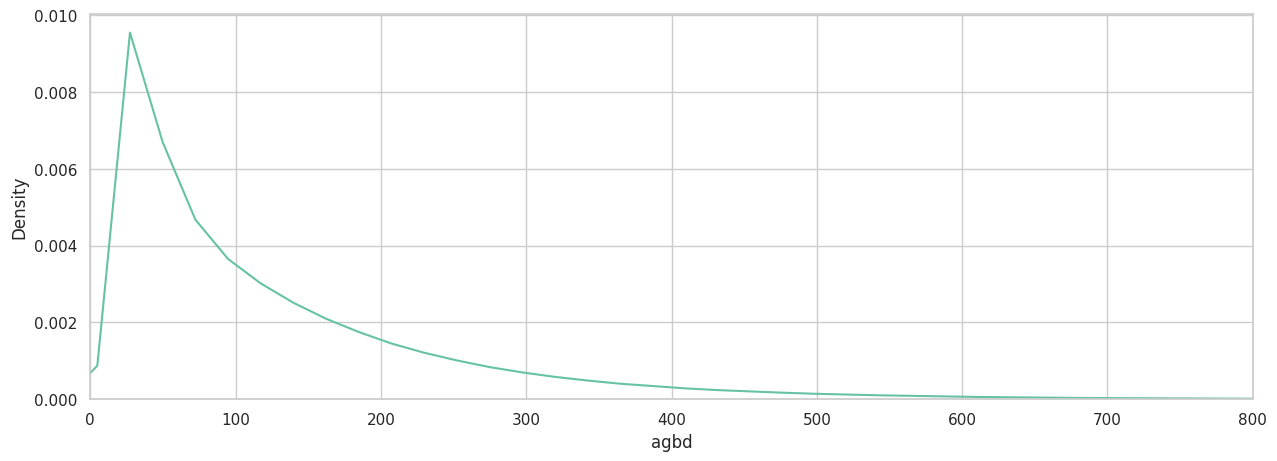

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.kdeplot(gedi_unburned, x="agbd")
ax.set_xlim((0, 800))

In [8]:
gedi_recovery_2x2 = regen_analysis.process_all_fires_with_rf_control_per_burn_year(f"{DATA_PATH}/rf/burned/2x2", f"{DATA_PATH}/rf/models")

Process fires for year 1985.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1986.
matching shots within fire
Processing data
Run RF to predict control AGBD.
Process fires for year 1987.
matching shots within fire
Processing data
Run RF to predict control AGBD.


KeyboardInterrupt: 

In [2]:
gedi_recovery_2x2 = load_pickle("/maps/fire-regen/data/gedi_ndvi_time_for_space_jun_28.pkl")

In [4]:
gedi_recovery = gedi_recovery_2x2[gedi_recovery_2x2.pft_class == 1]

In [11]:
gedi_recovery = gedi_recovery.astype({'burn_year': 'int32', 'severity': 'int32'})
gedi_recovery = gedi_recovery.astype({'burn_year': 'int32', 'severity': 'category'})
gedi_recovery['severity'] = gedi_recovery.severity.cat.set_categories(["Low", "Medium", "High"], True, True)
gedi_recovery = gedi_recovery.astype({'time_since_burn': 'int32'})

ValueError: Cannot cast object dtype to int32: Error while type casting for column 'severity'

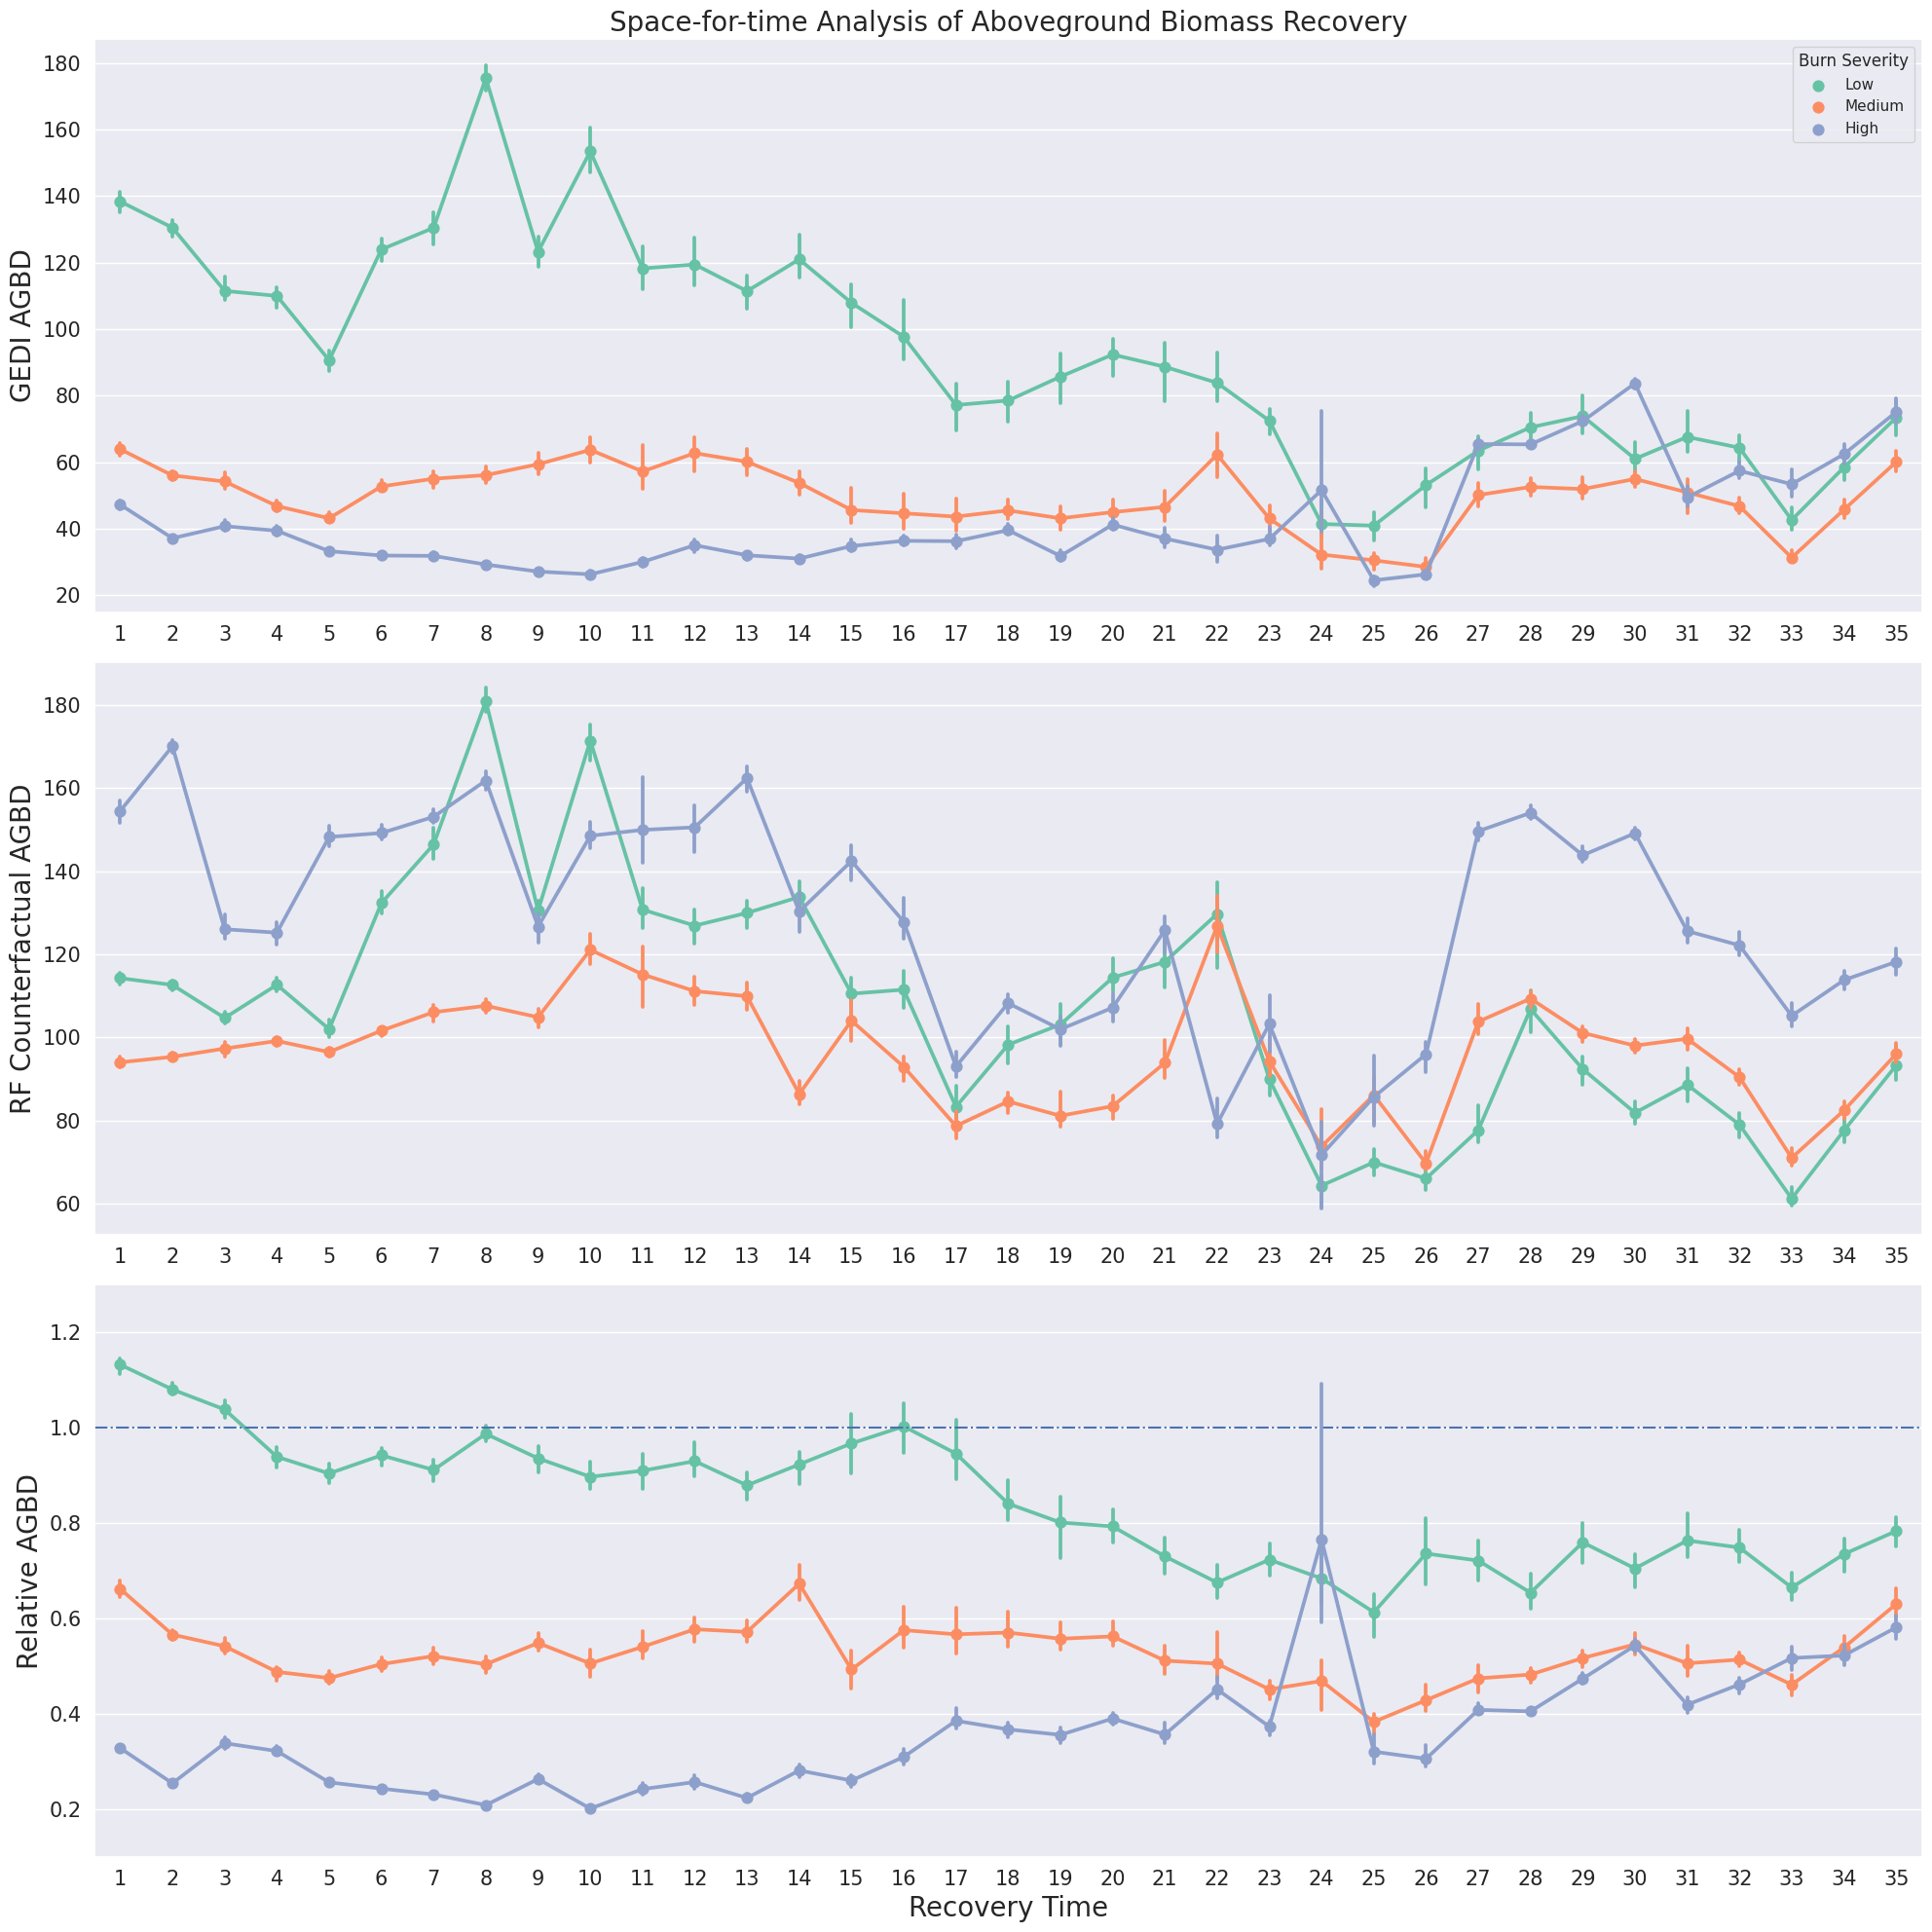

In [8]:
to_plot = gedi_recovery[gedi_recovery.time_since_burn < 36].copy()
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(to_plot, x='time_since_burn', y='agbd', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='agbd_control', hue='severity', estimator='median', ax=ax[1], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='rel_agbd', hue='severity', estimator='median', ax=ax[2], palette="Set2")
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("Space-for-time Analysis of Aboveground Biomass Recovery", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].get_legend().remove()
ax[2].get_legend().remove()

ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[2].set_xlabel("Recovery Time", fontsize=20)

for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=20)
ax[1].set_ylabel("RF Counterfactual AGBD", fontsize=20)
ax[2].set_ylabel("Relative AGBD", fontsize=20)


ax[2].set_ylim((0.1, 1.3))
fig.tight_layout()

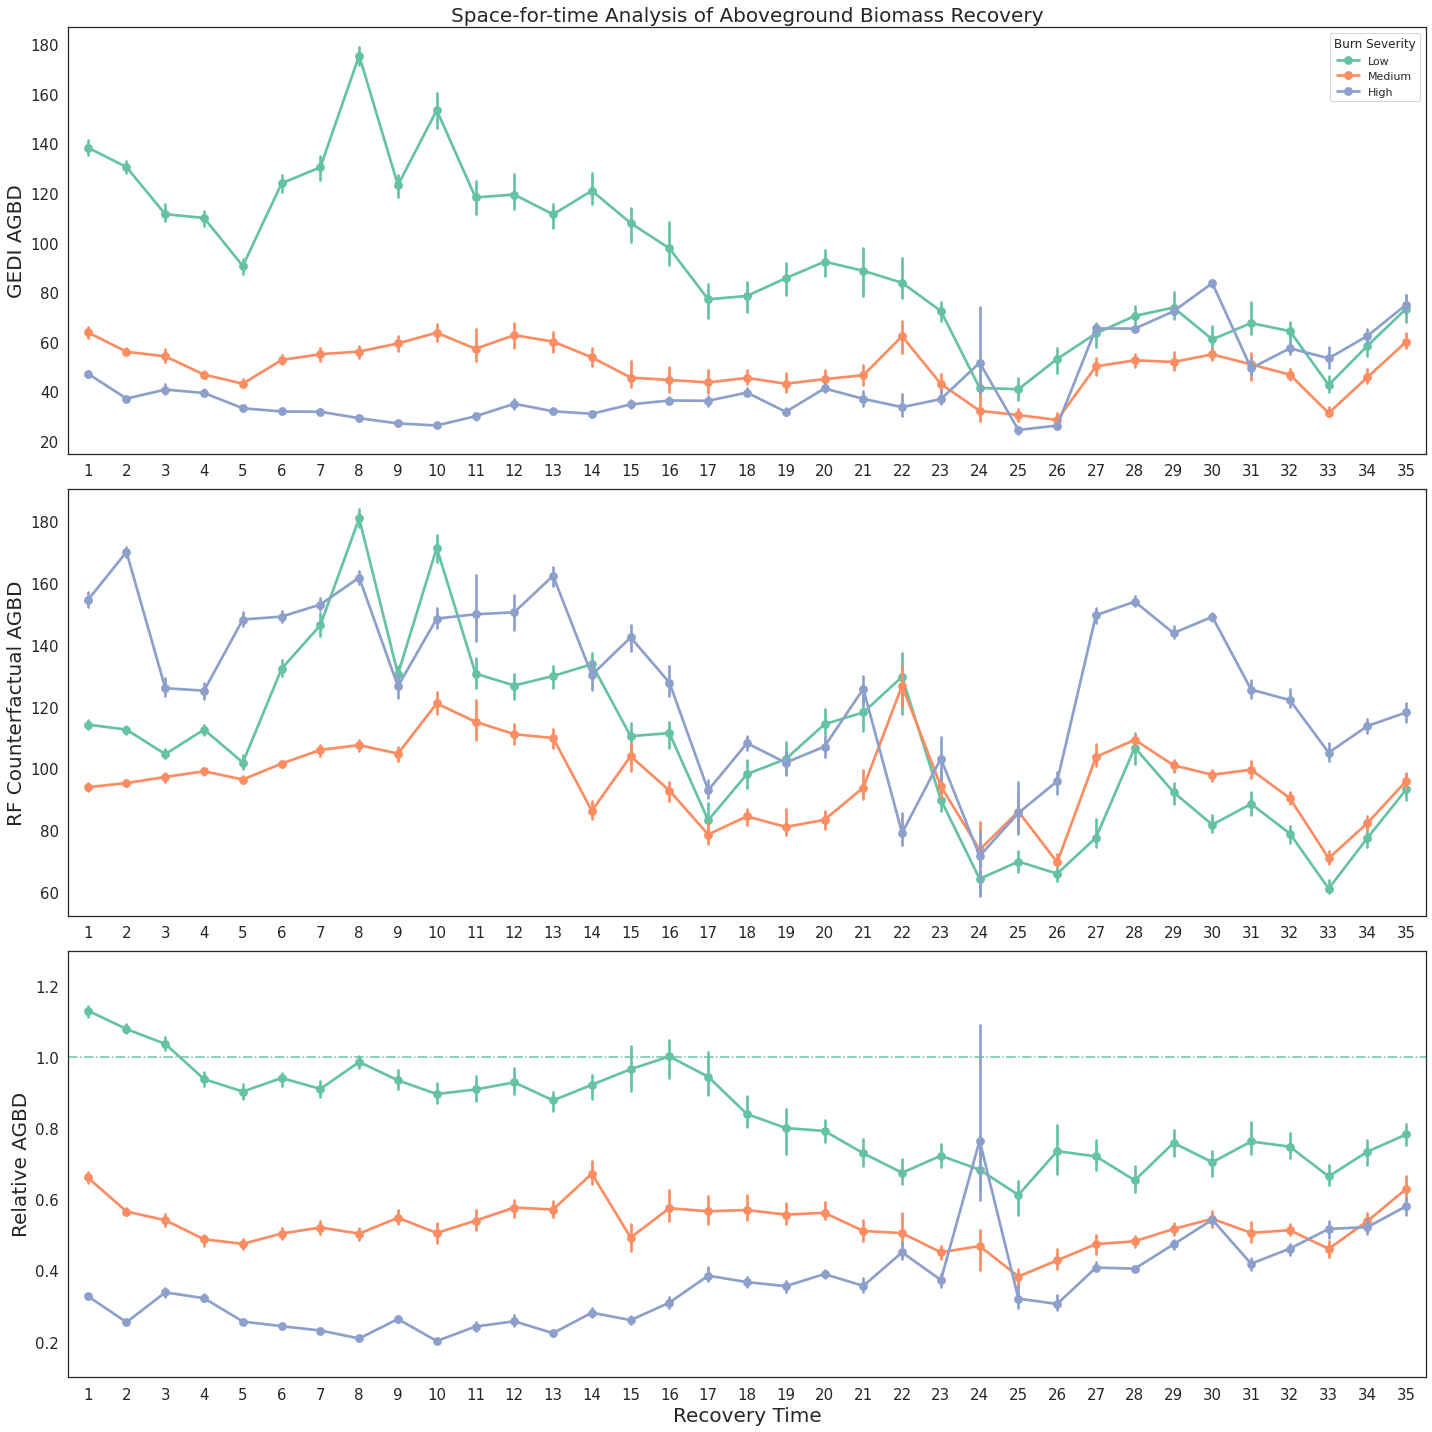

In [5]:
to_plot = gedi_recovery[gedi_recovery.time_since_burn < 36].copy()
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(to_plot, x='time_since_burn', y='agbd', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='agbd_control', hue='severity', estimator='median', ax=ax[1], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='rel_agbd', hue='severity', estimator='median', ax=ax[2], palette="Set2")
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("Space-for-time Analysis of Aboveground Biomass Recovery", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].get_legend().remove()
ax[2].get_legend().remove()

ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[2].set_xlabel("Recovery Time", fontsize=20)

for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=20)
ax[1].set_ylabel("RF Counterfactual AGBD", fontsize=20)
ax[2].set_ylabel("Relative AGBD", fontsize=20)


ax[2].set_ylim((0.1, 1.3))
fig.tight_layout()

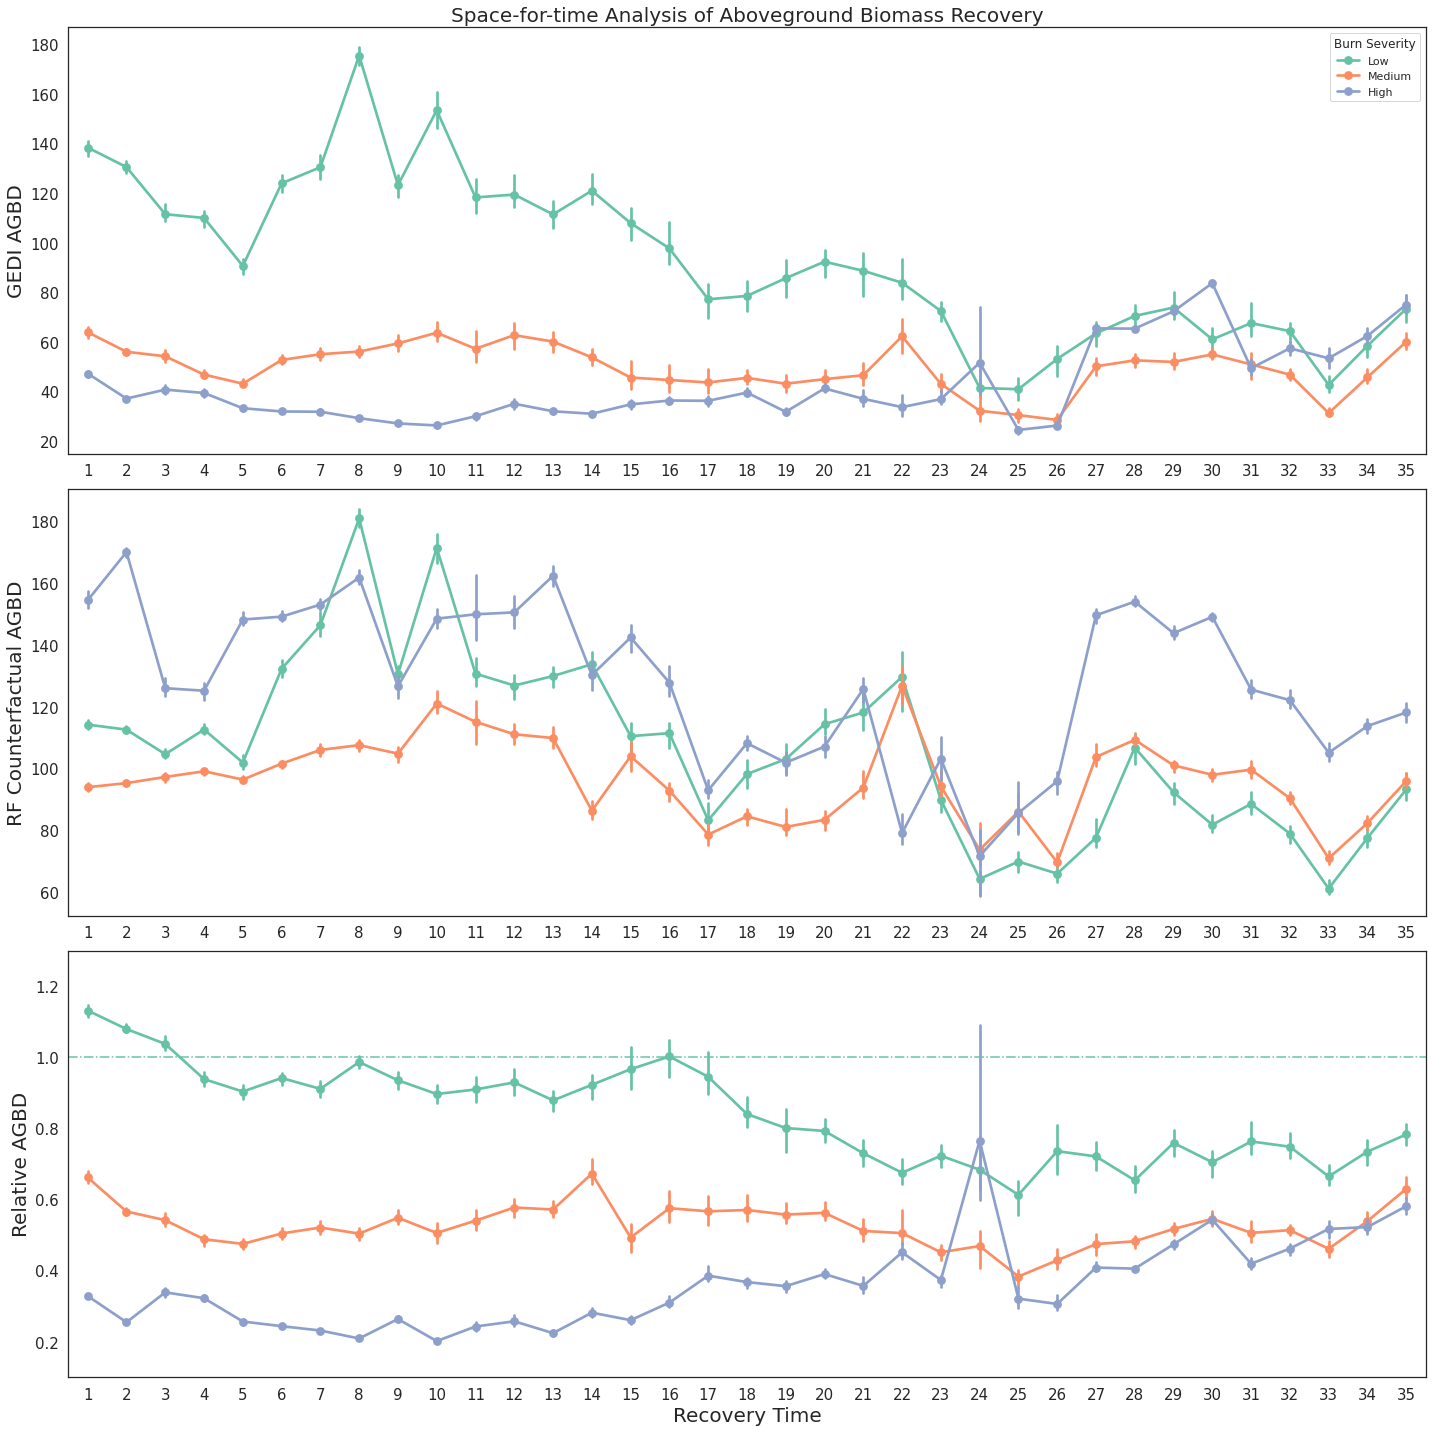

In [6]:
to_plot = gedi_recovery_2x2[gedi_recovery_2x2.time_since_burn < 36].copy()
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(to_plot, x='time_since_burn', y='agbd', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='agbd_control', hue='severity', estimator='median', ax=ax[1], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='rel_agbd', hue='severity', estimator='median', ax=ax[2], palette="Set2")
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("Space-for-time Analysis of Aboveground Biomass Recovery", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].get_legend().remove()
ax[2].get_legend().remove()

ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[2].set_xlabel("Recovery Time", fontsize=20)

for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=20)
ax[1].set_ylabel("RF Counterfactual AGBD", fontsize=20)
ax[2].set_ylabel("Relative AGBD", fontsize=20)


ax[2].set_ylim((0.1, 1.3))
fig.tight_layout()

### Interpolate AGBD recovery

In [7]:
def interpolate_using_weighted_average_without_severity(df, value, weight):
    subset = df.copy()
    subset = subset.sort_values("time_since_burn")
    weighted_values = subset[value] * subset[weight]

    sum_of_weighted_values = weighted_values.rolling(
        window=3, center=True).sum()
    
    sum_of_weights = subset[weight].rolling(window=3, center=True).sum()
    interpolated_value = (sum_of_weighted_values / sum_of_weights).values

    interpolated_value[0] = subset[value].values[0]

    subset[f'{value}_interpolated'] = interpolated_value
    return subset

In [8]:
def interpolate_using_weighted_average(df, value, weight):
    result = []
    for severity in ["Low", "Medium", "High"]:
        subset = df[df.severity == severity]
        subset = subset.sort_values("time_since_burn")
        weighted_values = subset[value] * subset[weight]

        sum_of_weighted_values = weighted_values.rolling(
            window=3, center=True).sum()
        
        sum_of_weights = subset[weight].rolling(window=3, center=True).sum()
        interpolated_value = (sum_of_weighted_values / sum_of_weights).values

        interpolated_value[0] = subset[value].values[0]

        subset[f'{value}_interpolated'] = interpolated_value

        

        result.append(subset)
    return pd.concat(result)

In [9]:
def calc_medians_and_interpolate(df, value):
    df_medians = df.groupby(["severity", "time_since_burn"]).median(numeric_only=True)[value].reset_index()
    df_counts = df.groupby(["severity", "time_since_burn"]).count()[value].reset_index()
    df_medians["weight"] = df_counts[value]
    return interpolate_using_weighted_average(df_medians, value, "weight")

def calc_medians_and_interpolate_without_severity(df, value):
    df_medians = df.groupby(["time_since_burn"]).median(numeric_only=True)[value].reset_index()
    df_counts = df.groupby(["time_since_burn"]).count()[value].reset_index()
    df_medians["weight"] = df_counts[value]
    return interpolate_using_weighted_average_without_severity(df_medians, value, "weight")

In [10]:
agbd_interpolated = calc_medians_and_interpolate_without_severity(gedi_recovery, "rel_agbd")

<AxesSubplot: xlabel='time_since_burn', ylabel='rel_agbd_interpolated'>

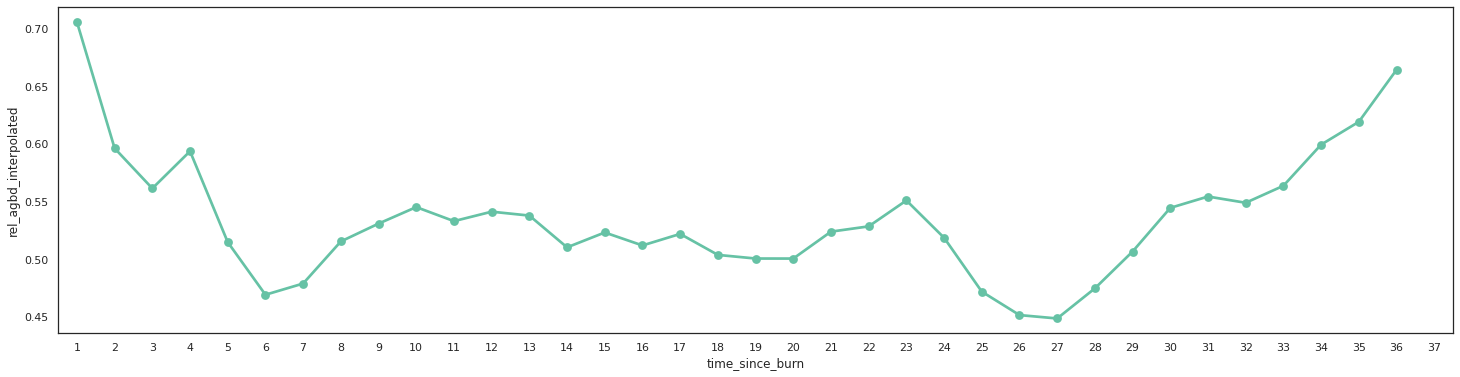

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.pointplot(agbd_interpolated, x='time_since_burn', y='rel_agbd_interpolated', estimator='median', ax=ax)

<AxesSubplot: xlabel='time_since_burn', ylabel='rel_agbd_interpolated'>

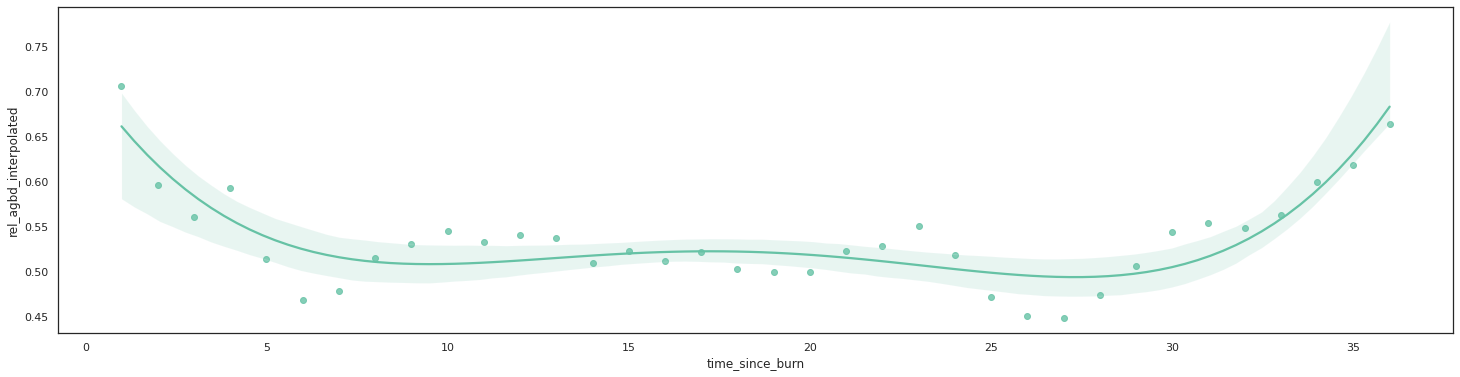

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(25, 6))
sns.regplot(agbd_interpolated, x='time_since_burn', y='rel_agbd_interpolated', ax=ax, order=4)

In [17]:
agbd_interpolated = calc_medians_and_interpolate(gedi_recovery, "rel_agbd")

/tmp/ipykernel_428903/613702771.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_medians = df.groupby(["severity", "time_since_burn"]).median(numeric_only=True)[value].reset_index()
/tmp/ipykernel_428903/613702771.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_counts = df.groupby(["severity", "time_since_burn"]).count()[value].reset_index()


In [20]:
agbd_interpolated

severity  time_since_burn  rel_agbd  weight  rel_agbd_interpolated
0        Low                1  1.132059   11737               1.132059
1        Low                2  1.080025   19583               1.090356
2        Low                3  1.038119    5497               1.039213
3        Low                4  0.939085    7922               0.956661
4        Low                5  0.904081    5868               0.930413
..       ...              ...       ...     ...                    ...
106     High               33  0.517431    1190               0.496589
107     High               34  0.522764    2273               0.538398
108     High               35  0.581482    1404               0.544298
109     High               36  0.423602      27               0.577330
110     High               37  0.241769       5                    NaN

[111 rows x 5 columns]

<AxesSubplot: xlabel='time_since_burn', ylabel='rel_agbd_interpolated'>

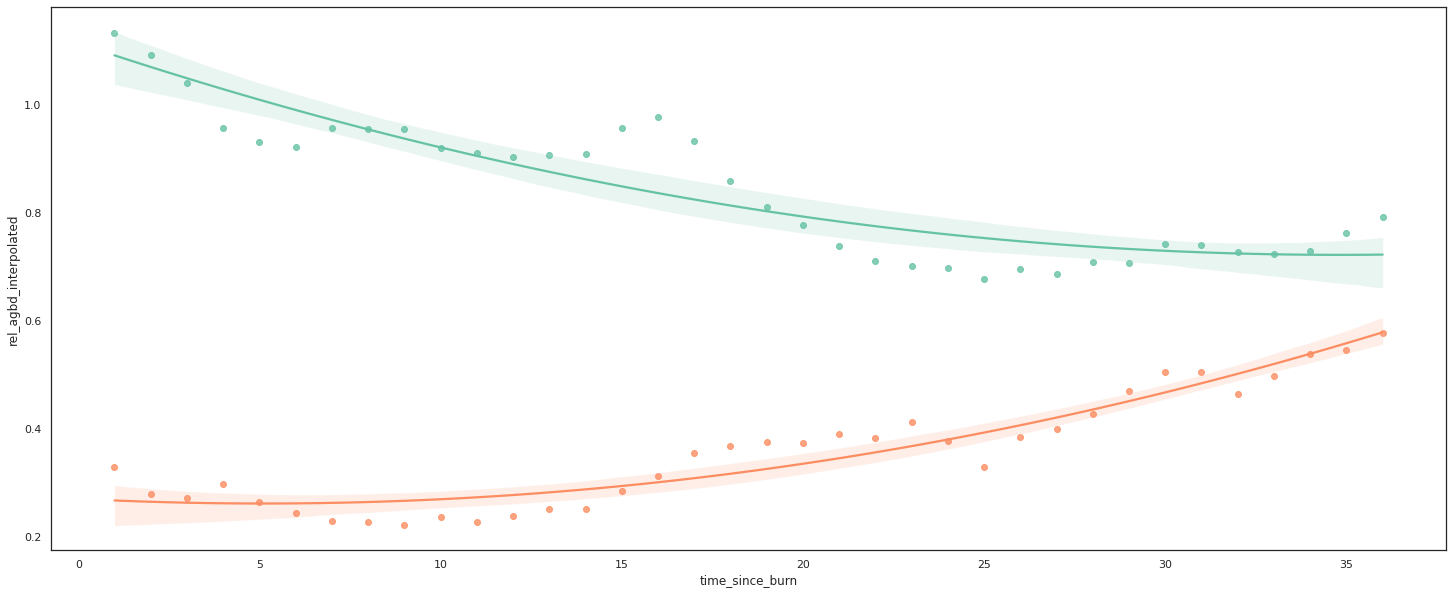

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.regplot(agbd_interpolated[agbd_interpolated.severity == "Low"], x='time_since_burn', y='rel_agbd_interpolated', ax=ax, order=2)
sns.regplot(agbd_interpolated[agbd_interpolated.severity == "High"], x='time_since_burn', y='rel_agbd_interpolated', ax=ax, order=2)

In [25]:
df_medians = gedi_recovery_2x2.groupby(["severity", "time_since_burn"]).median(numeric_only=True).reset_index()

/tmp/ipykernel_428903/3972579813.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_medians = gedi_recovery_2x2.groupby(["severity", "time_since_burn"]).median(numeric_only=True).reset_index()


<AxesSubplot: xlabel='time_since_burn', ylabel='rel_agbd'>

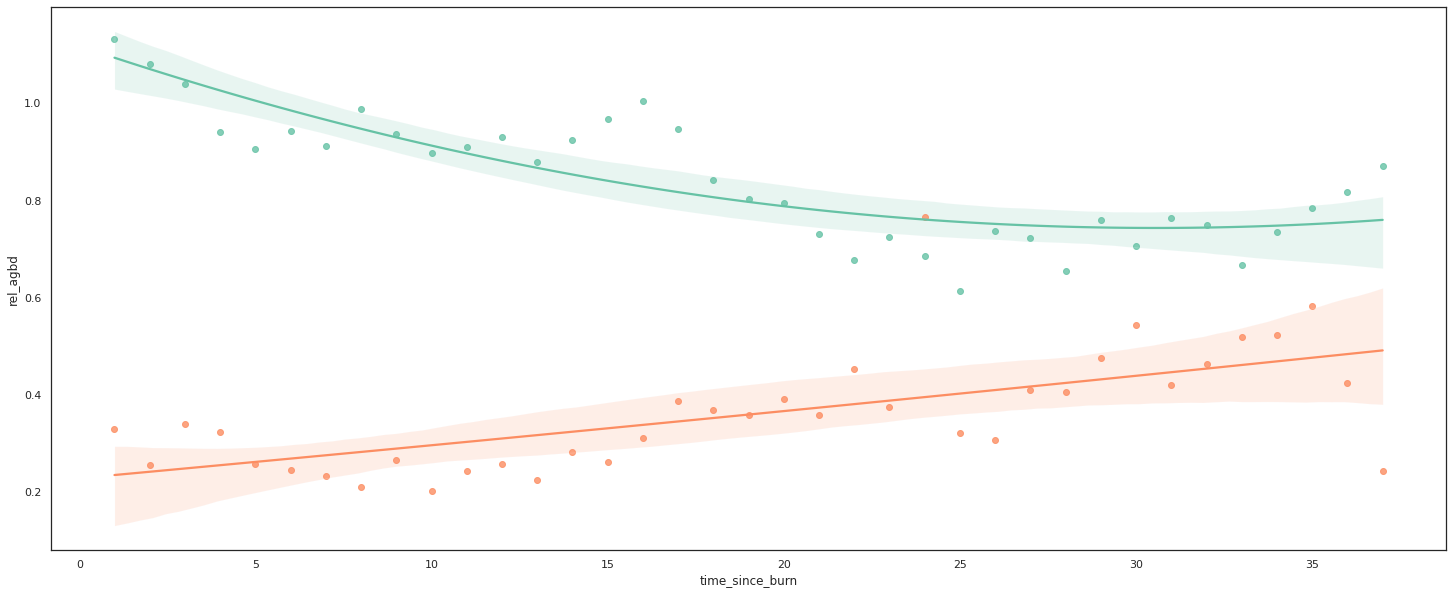

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(25, 10))
sns.regplot(df_medians[df_medians.severity == "Low"], x='time_since_burn', y='rel_agbd', ax=ax, order=2)
sns.regplot(df_medians[df_medians.severity == "High"], x='time_since_burn', y='rel_agbd', ax=ax, order=2)

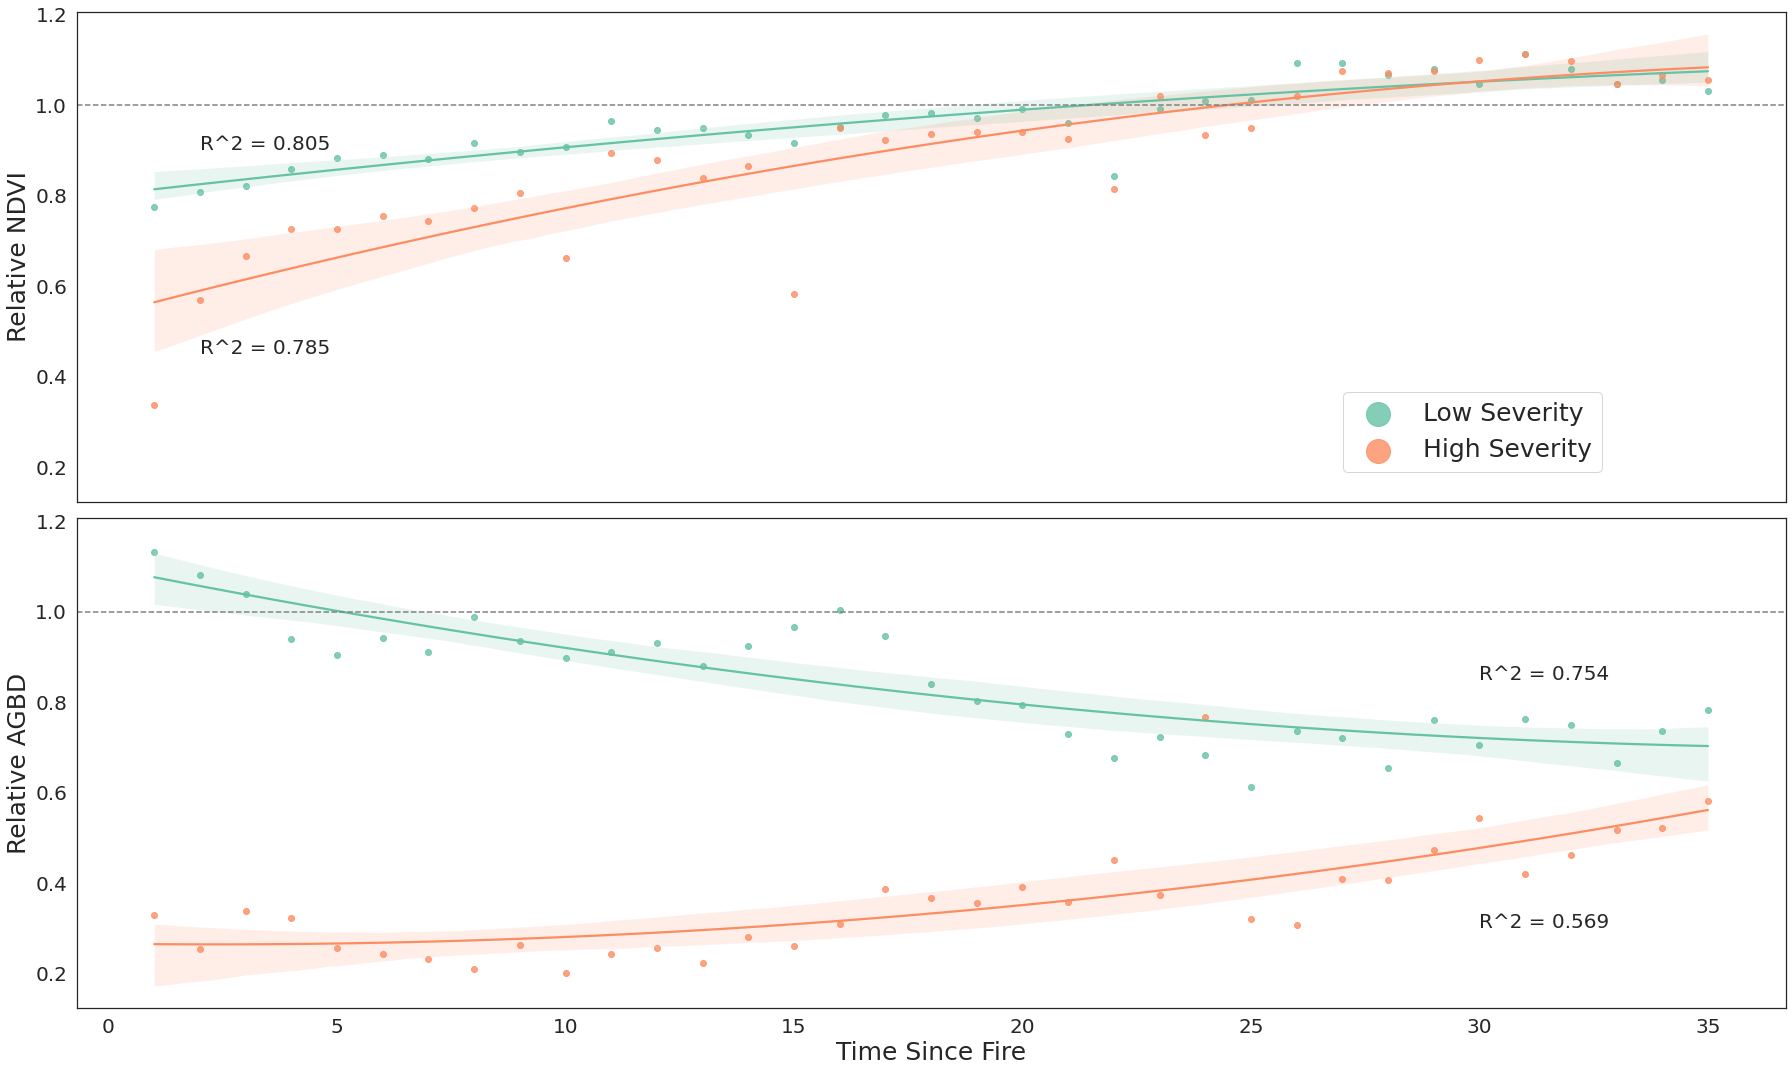

In [80]:
fig, ax = plt.subplots(2, 1, figsize=(25, 15), sharex=True, sharey=True)
df_medians = df_medians[df_medians.time_since_burn < 36]
agbd_interpolated = agbd_interpolated[agbd_interpolated.time_since_burn < 36]
#sns.regplot(agbd_interpolated[agbd_interpolated.severity == "Low"], x='time_since_burn', y='rel_agbd_interpolated', ax=ax[0], order=2)
#sns.regplot(agbd_interpolated[agbd_interpolated.severity == "High"], x='time_since_burn', y='rel_agbd_interpolated', ax=ax[0], order=2)
sns.regplot(df_medians[df_medians.severity == "Low"], x='time_since_burn', y='rel_agbd', ax=ax[1], order=2)
ax[1].text(30, 0.85, "R^2 = 0.754", fontsize=20)
sns.regplot(df_medians[df_medians.severity == "High"], x='time_since_burn', y='rel_agbd', ax=ax[1], order=2)
ax[1].text(30, 0.3, "R^2 = 0.569", fontsize=20)
sns.regplot(df_medians[df_medians.severity == "Low"], x='time_since_burn', y='rel_NDVI', ax=ax[0], order=2, label="Low Severity")
ax[0].text(2, 0.90, "R^2 = 0.805", fontsize=20)
sns.regplot(df_medians[df_medians.severity == "High"], x='time_since_burn', y='rel_NDVI', ax=ax[0], order=2, label="High Severity")
ax[0].text(2, 0.45, "R^2 = 0.785", fontsize=20)
ax[1].axhline(1.0, linestyle="--", color="gray")
ax[0].axhline(1.0, linestyle="--", color="gray")
ax[0].legend(fontsize=25, loc='best', bbox_to_anchor=(0.4, 0., 0.5, 0.25), markerscale=4)
ax[0].set_xlabel("", fontsize=25)
ax[0].tick_params(axis='both', which='major', labelsize=20)
ax[1].tick_params(axis='both', which='major', labelsize=20)
#ax[1].set_yticks(fontsize=20)
ax[1].set_xlabel("Time Since Fire", fontsize=25)
ax[1].set_ylabel("Relative AGBD", fontsize=25)
ax[0].set_ylabel("Relative NDVI", fontsize=25)
fig.tight_layout()

In [57]:
import statsmodels.api as sm
x = np.array(range(1, 36))
y = df_medians[df_medians.severity == "Low"].rel_NDVI.to_numpy()
X = sm.add_constant(np.stack([x, x**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.793
Method:                 Least Squares   F-statistic:                     65.98
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           4.43e-12
Time:                        15:08:12   Log-Likelihood:                 64.379
No. Observations:                  35   AIC:                            -122.8
Df Residuals:                      32   BIC:                            -118.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.8026      0.022     37.130      0.0

In [55]:
import statsmodels.api as sm
x = np.array(range(1, 36))
y = df_medians[df_medians.severity == "High"].rel_NDVI.to_numpy()
X = sm.add_constant(np.stack([x, x**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     58.32
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           2.13e-11
Time:                        15:07:21   Log-Likelihood:                 37.807
No. Observations:                  35   AIC:                            -69.61
Df Residuals:                      32   BIC:                            -64.95
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5380      0.046     11.650      0.0

In [50]:
import statsmodels.api as sm
x = np.array(range(1, 36))
y = df_medians[df_medians.severity == "High"].rel_agbd.to_numpy()
X = sm.add_constant(np.stack([x, x**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.569
Model:                            OLS   Adj. R-squared:                  0.542
Method:                 Least Squares   F-statistic:                     21.10
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           1.43e-06
Time:                        15:04:06   Log-Likelihood:                 38.802
No. Observations:                  35   AIC:                            -71.60
Df Residuals:                      32   BIC:                            -66.94
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2661      0.045      5.927      0.0

In [47]:
import statsmodels.api as sm
x = np.array(range(1, 36))
y = df_medians[df_medians.severity == "Low"].rel_agbd.to_numpy()
X = sm.add_constant(np.stack([x, x**2]).T)
model = sm.OLS(y, X)
fitted_model = model.fit()
print(fitted_model.summary(xname=['const', 'x1', 'x2']))  

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.754
Model:                            OLS   Adj. R-squared:                  0.738
Method:                 Least Squares   F-statistic:                     48.94
Date:                Sun, 05 Nov 2023   Prob (F-statistic):           1.84e-10
Time:                        15:00:48   Log-Likelihood:                 46.136
No. Observations:                  35   AIC:                            -86.27
Df Residuals:                      32   BIC:                            -81.61
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0959      0.036     30.106      0.0

In [29]:
df_medians.columns

Index(['severity', 'time_since_burn', 'index', 'shot_number', 'longitude',
       'latitude', 'agbd', 'agbd_pi_lower', 'agbd_pi_upper', 'agbd_se',
       ...
       'NDVI_median', 'ndvi_2020', 'ndvi_2021', 'ndvi_2022', 'rel_NDVI_2019',
       'rel_NDVI_2020', 'rel_NDVI_2021', 'rel_NDVI_2022', 'rel_NDVI',
       'NDVI_mean'],
      dtype='object', length=136)

In [9]:
sns.pointplot(to_plot, x='time_since_burn', y='agbd', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='agbd_control', hue='severity', estimator='median', ax=ax[1], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='rel_agbd', hue='severity', estimator='median', ax=ax[2], palette="Set2")

NameError: name 'to_plot' is not defined

In [32]:
ndvi_medians = gedi_recovery.groupby(["severity", "time_since_burn"]).median(numeric_only=True).rel_NDVI.reset_index()
ndvi_counts = gedi_recovery.groupby(["severity", "time_since_burn"]).count().rel_NDVI.reset_index()
ndvi_medians["weight"] = ndvi_counts.rel_NDVI
agbd_interpolated = interpolate_using_weighted_average(ndvi_medians, "rel_NDVI", "weight")

AttributeError: 'DataFrame' object has no attribute 'rel_NDVI'

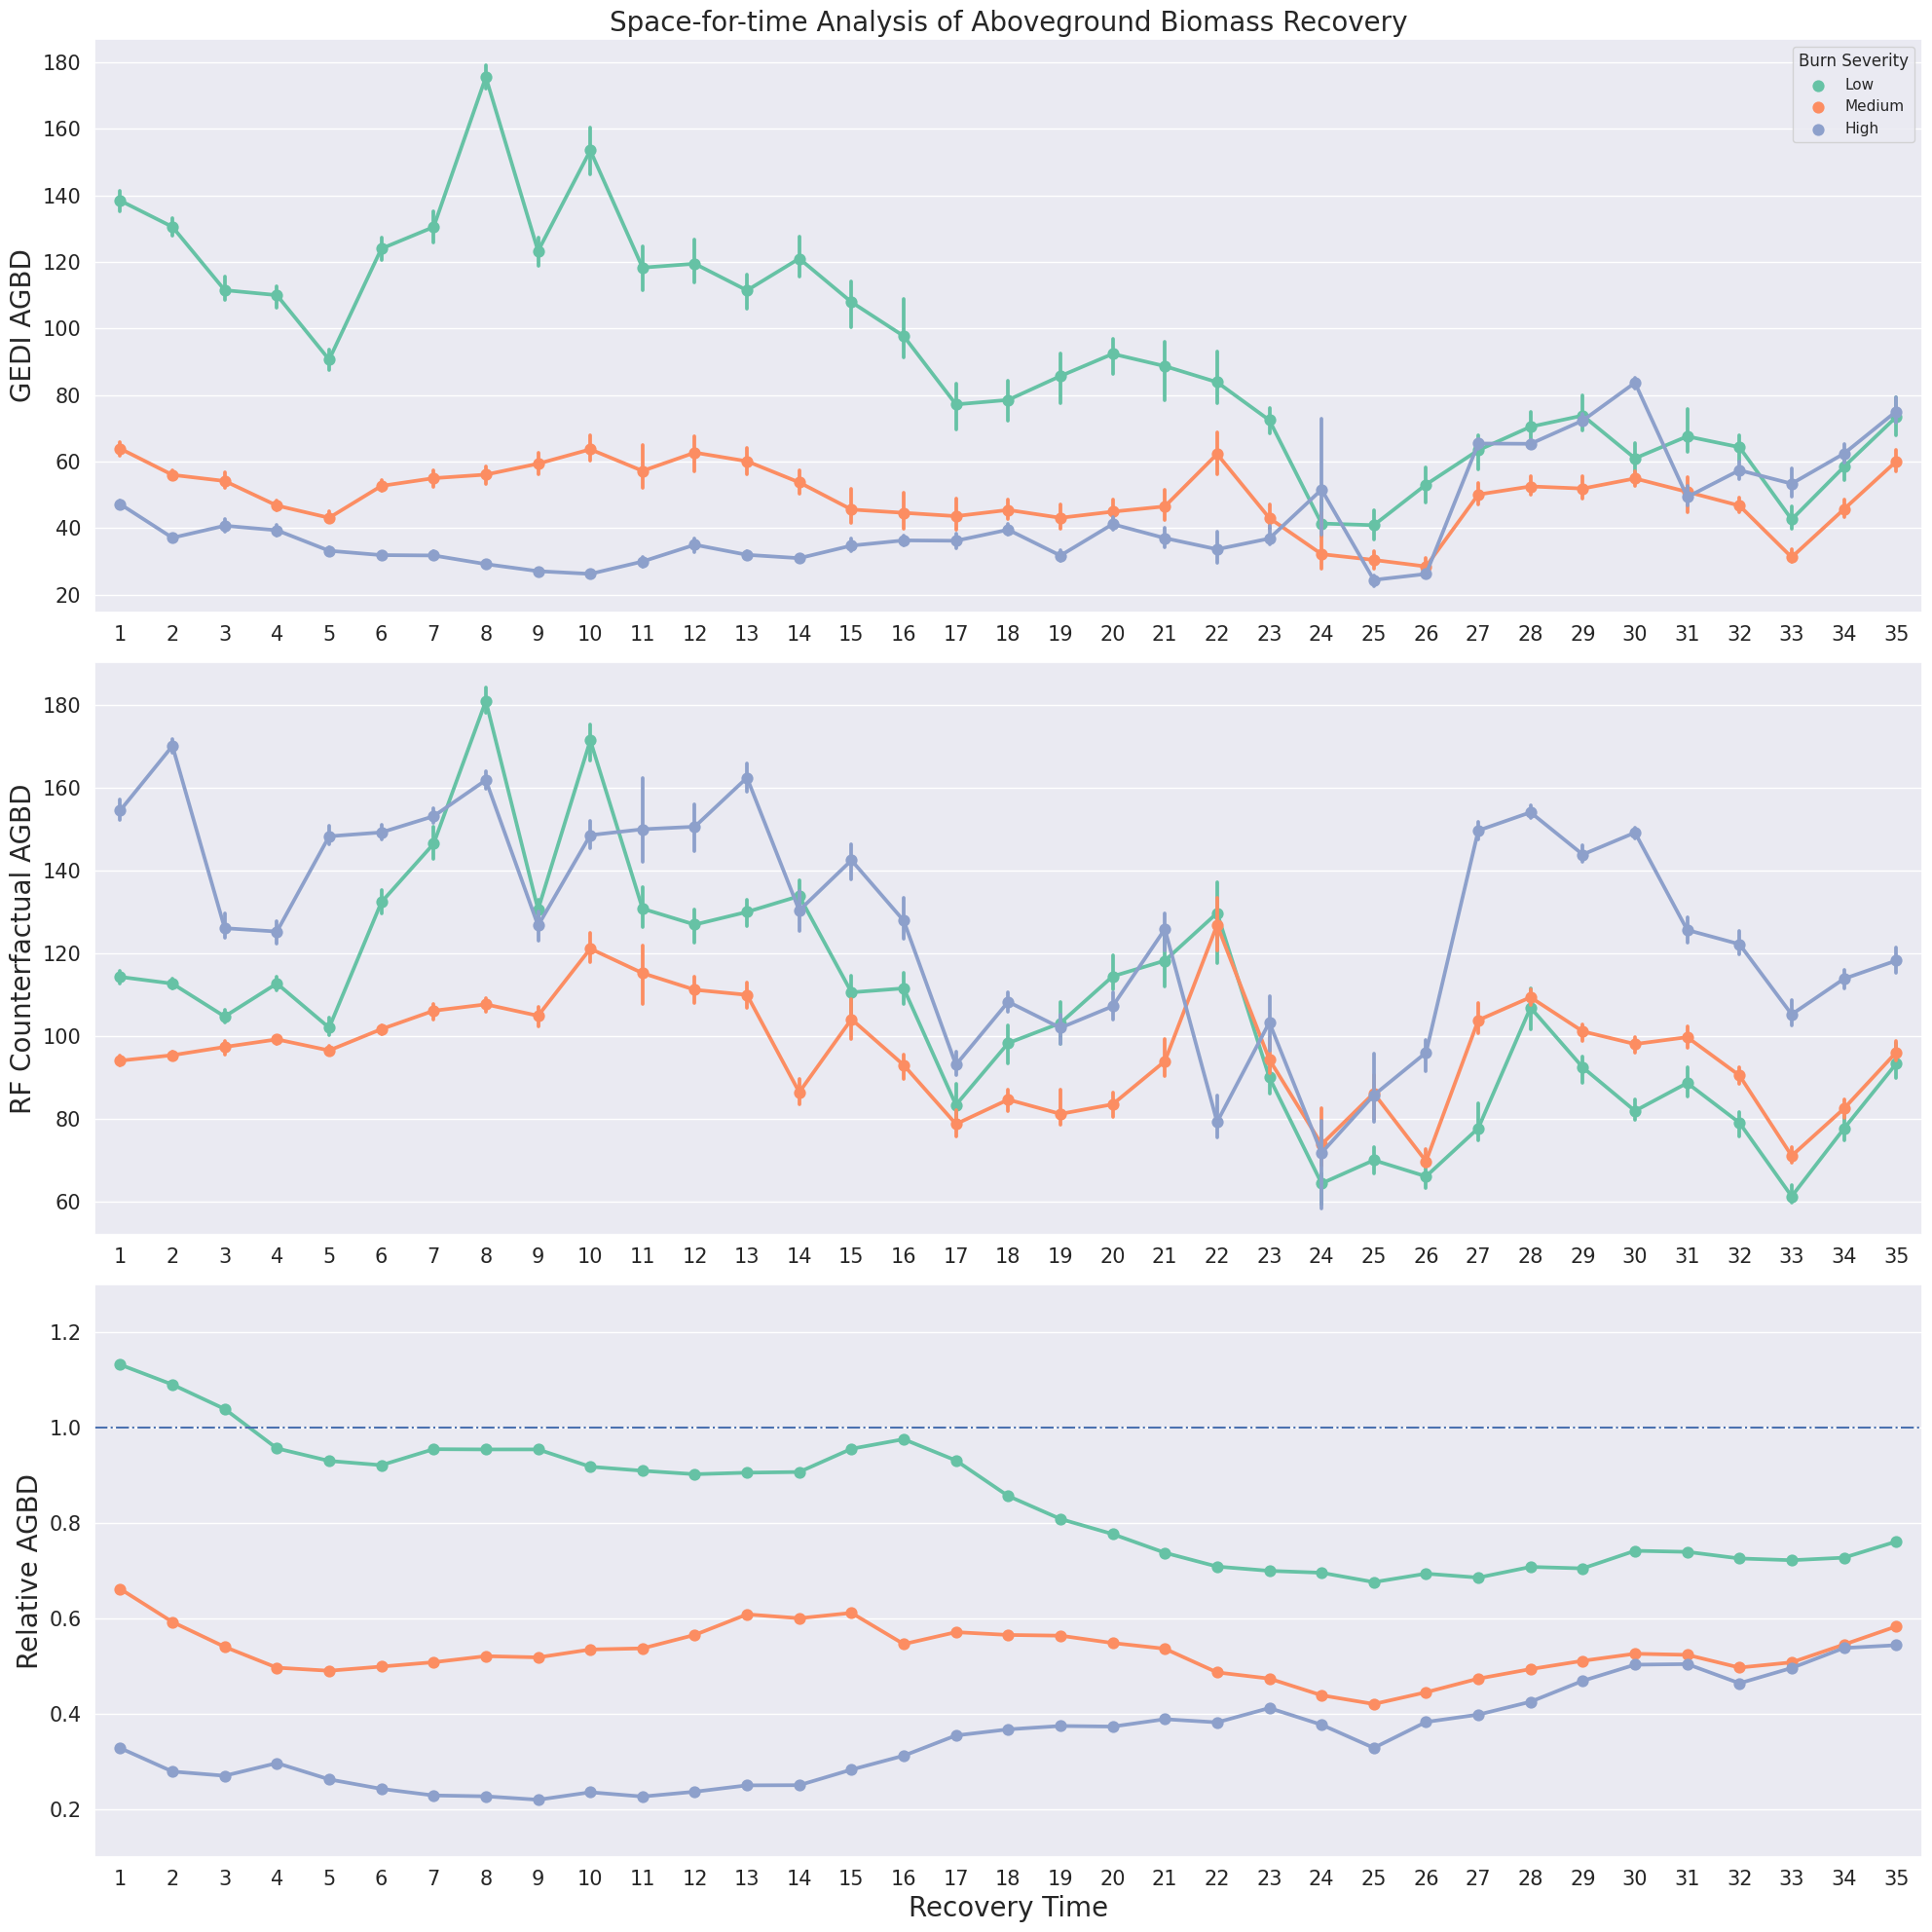

In [10]:
to_plot = gedi_recovery[gedi_recovery.time_since_burn < 36].copy()
fig, ax = plt.subplots(3, 1, figsize=(20, 20))
sns.pointplot(to_plot, x='time_since_burn', y='agbd', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(to_plot, x='time_since_burn', y='agbd_control', hue='severity', estimator='median', ax=ax[1], palette="Set2")
sns.pointplot(agbd_interpolated[agbd_interpolated.time_since_burn < 36], x='time_since_burn', y='rel_agbd_interpolated', hue='severity', estimator='median', ax=ax[2], palette="Set2")
ax[2].axhline(y=1, linestyle="-.")

ax[0].set_title("Space-for-time Analysis of Aboveground Biomass Recovery", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].get_legend().remove()
ax[2].get_legend().remove()

ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[2].set_xlabel("Recovery Time", fontsize=20)

for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=20)
ax[1].set_ylabel("RF Counterfactual AGBD", fontsize=20)
ax[2].set_ylabel("Relative AGBD", fontsize=20)


ax[2].set_ylim((0.1, 1.3))
fig.tight_layout()

In [21]:
agbd_interpolated

severity  time_since_burn  rel_agbd  weight  rel_agbd_interpolated
0        Low                1  1.132059   11737               1.132059
1        Low                2  1.080025   19583               1.090356
2        Low                3  1.038119    5497               1.039213
3        Low                4  0.939085    7922               0.956661
4        Low                5  0.904081    5868               0.930413
..       ...              ...       ...     ...                    ...
106     High               33  0.517431    1190               0.496589
107     High               34  0.522764    2273               0.538398
108     High               35  0.581482    1404               0.544298
109     High               36  0.423602      27               0.577330
110     High               37  0.241769       5                    NaN

[111 rows x 5 columns]

In [31]:
palette = sns.color_palette("Set2")
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


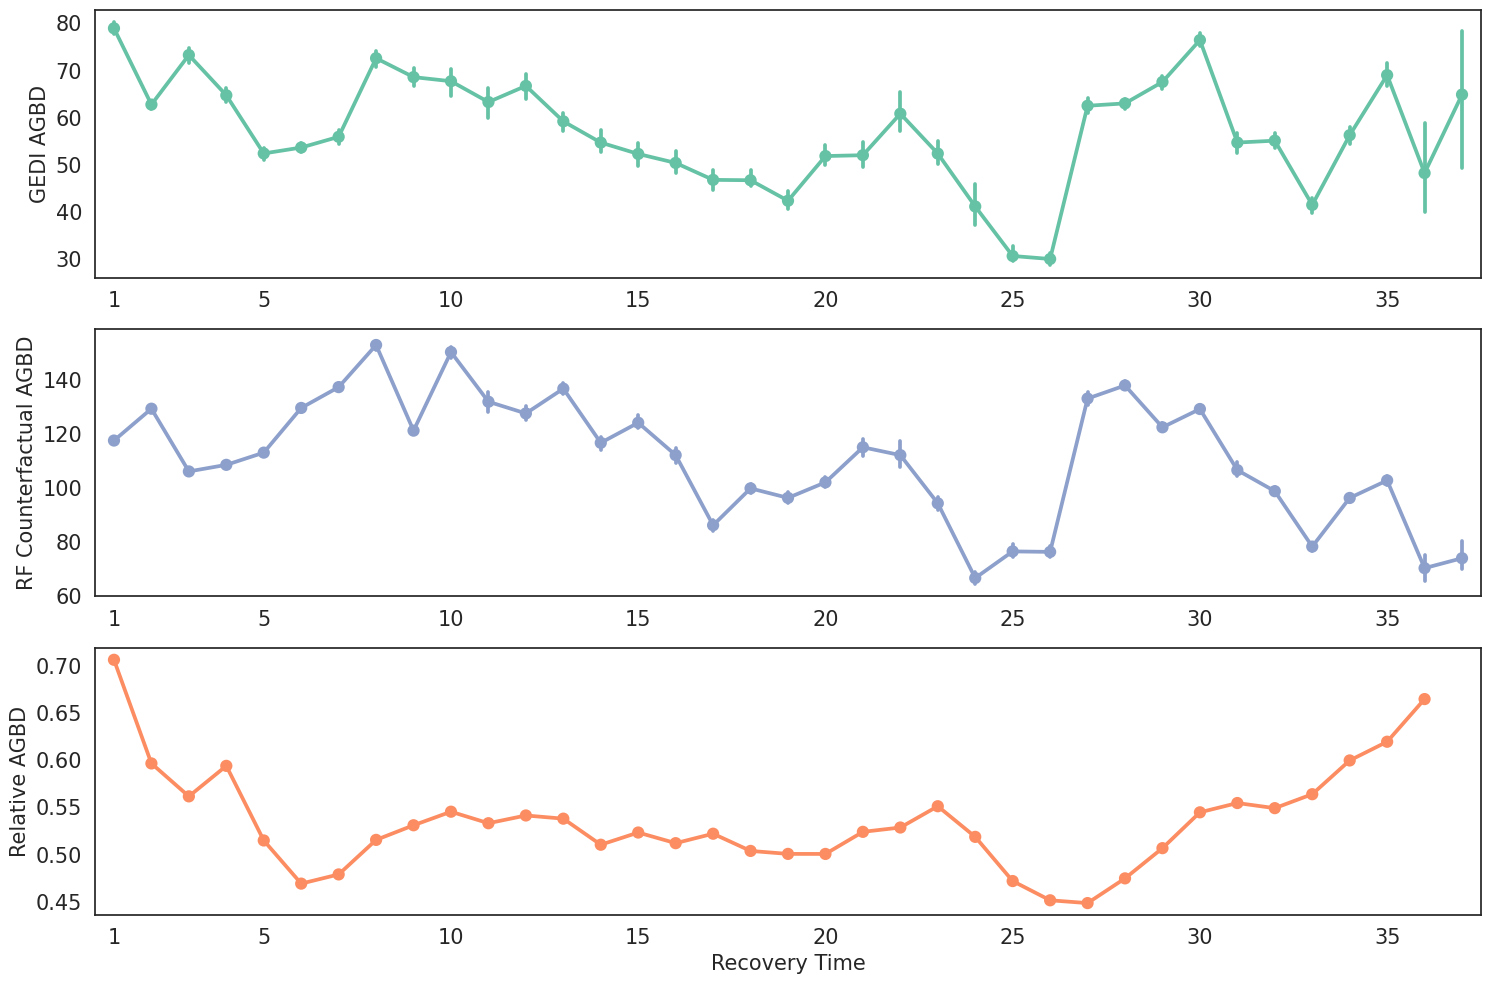

In [39]:
to_plot = gedi_recovery.copy()
fig, ax = plt.subplots(3, 1, figsize=(15, 10))
sns.pointplot(to_plot, x='time_since_burn', y='agbd', estimator='median', ax=ax[0], color=palette[0])
sns.pointplot(to_plot, x='time_since_burn', y='agbd_control', estimator='median', ax=ax[1], color=palette[2])
sns.pointplot(agbd_interpolated, x='time_since_burn', y='rel_agbd_interpolated', estimator='median', ax=ax[2], color=palette[1])
#ax[2].axhline(y=1, linestyle="-.")

#ax[0].set_title("Space-for-time Analysis of Aboveground Biomass Recovery", fontsize=20)

#ax[0].legend(title='Burn Severity')
#ax[1].get_legend().remove()
#ax[2].get_legend().remove()

ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("", fontsize=15)
ax[2].set_xlabel("Recovery Time", fontsize=15)

for i in range(3):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=15)
ax[1].set_ylabel("RF Counterfactual AGBD", fontsize=15)
ax[2].set_ylabel("Relative AGBD", fontsize=15)

ax[0].set_xticks([0, 4, 9, 14, 19, 24, 29, 34])
ax[1].set_xticks([0, 4, 9, 14, 19, 24, 29, 34])
ax[2].set_xticks([0, 4, 9, 14, 19, 24, 29, 34])
fig.tight_layout()

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


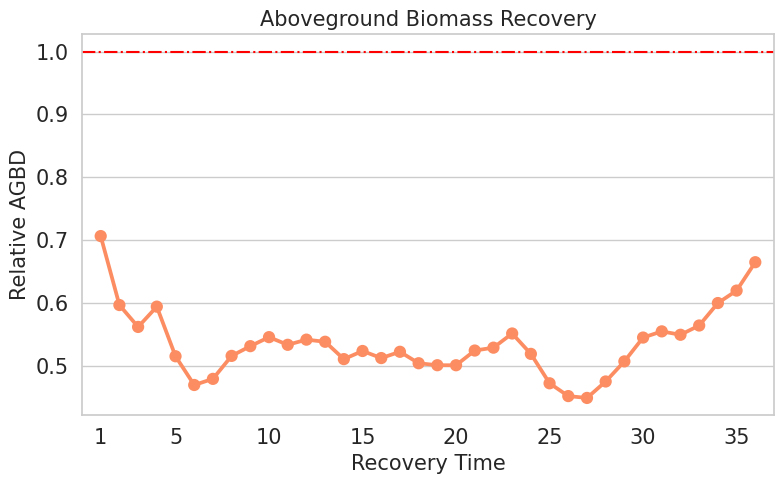

In [51]:
sns.set_theme(style="whitegrid", palette="Set2")
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
sns.pointplot(agbd_interpolated, x='time_since_burn', y='rel_agbd_interpolated', estimator='median', ax=ax, color=palette[1])
ax.axhline(y=1, linestyle="-.", color="red")
#ax[2].axhline(y=1, linestyle="-.")

ax.set_title("Aboveground Biomass Recovery", fontsize=15)

#ax[0].legend(title='Burn Severity')
#ax[1].get_legend().remove()
#ax[2].get_legend().remove()
ax.set_xlabel("Recovery Time", fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=15)

ax.set_ylabel("Relative AGBD", fontsize=15)

ax.set_xticks([0, 4, 9, 14, 19, 24, 29, 34])
ax.set_xlim((-1, 36))
fig.tight_layout()

<Axes: xlabel='time_since_burn', ylabel='rel_agbd_interpolated'>

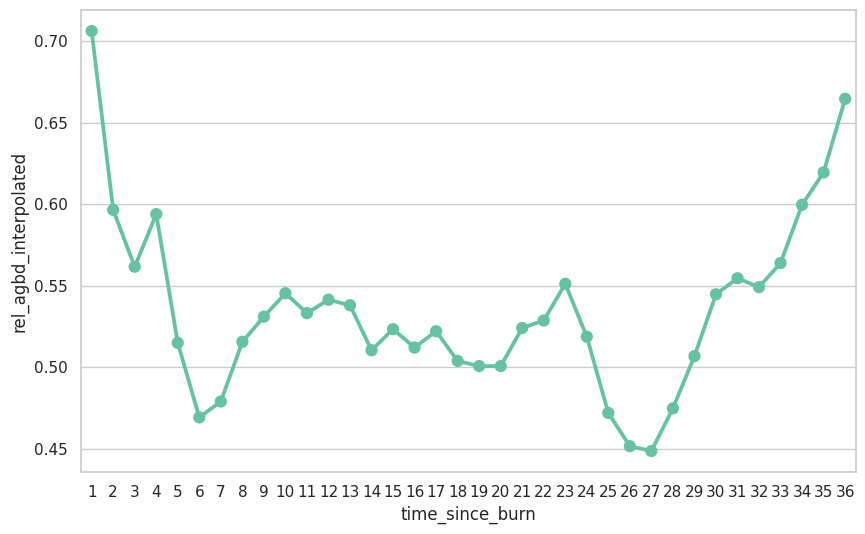

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.pointplot(agbd_interpolated[agbd_interpolated.time_since_burn < 37], x='time_since_burn', y='rel_agbd_interpolated', estimator='median', ax=ax)
#loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
#ax.xaxis.set_major_locator(loc)
#ax.set_xticklabels(range(3, 37, 3))
#ax.axhline(y=1, linestyle="-.")
#ax.set_ylim((0, 1.1))

In [69]:
agbd_interpolated.rel_agbd_interpolated

0     0.706412
1     0.596639
2     0.561777
3     0.594078
4     0.515072
5     0.469361
6     0.479110
7     0.515680
8     0.531172
9     0.545536
10    0.533329
11    0.541542
12    0.538159
13    0.510546
14    0.523478
15    0.512206
16    0.522220
17    0.503993
18    0.500844
19    0.500804
20    0.524204
21    0.528781
22    0.551323
23    0.518883
24    0.472072
25    0.451701
26    0.448748
27    0.474927
28    0.506920
29    0.544865
30    0.554712
31    0.549291
32    0.564056
33    0.599810
34    0.619640
35    0.664812
36         NaN
Name: rel_agbd_interpolated, dtype: float64

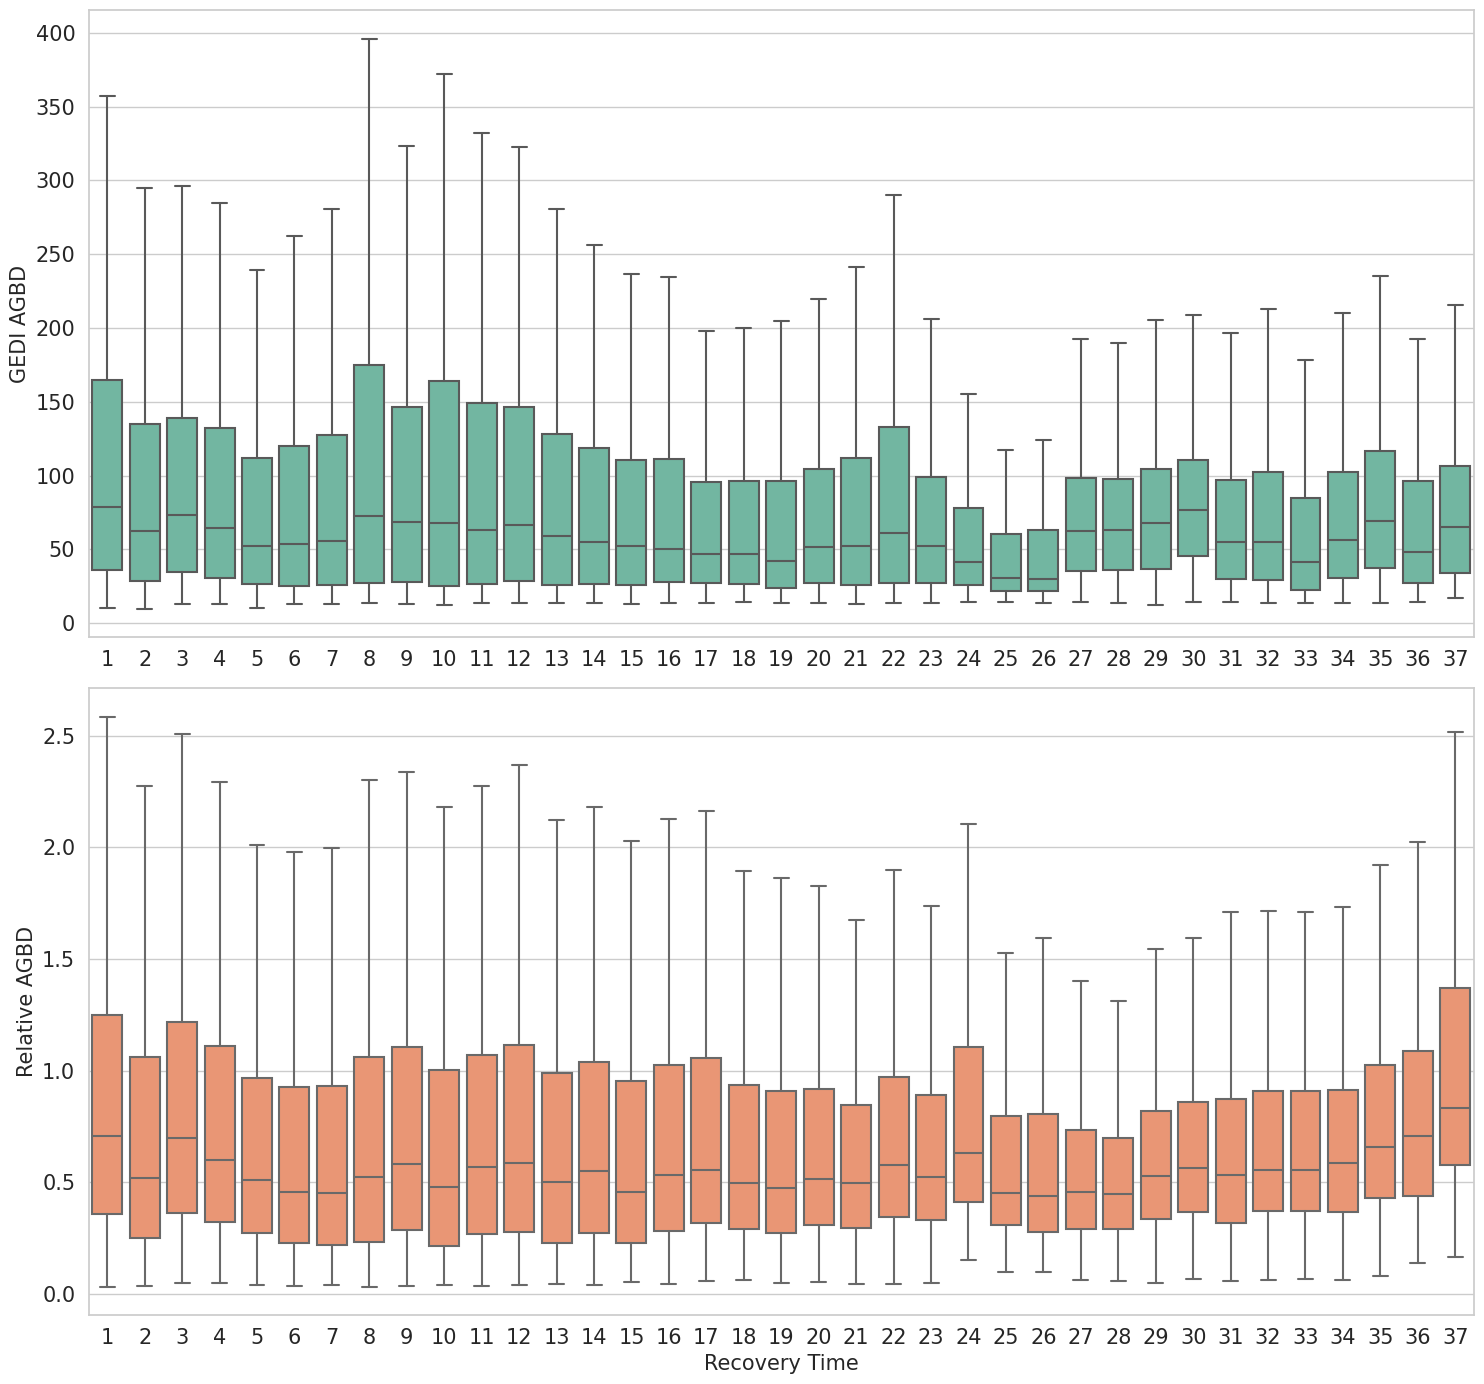

In [56]:
fig, ax = plt.subplots(2, 1, figsize=(15, 14))
sns.boxplot(gedi_recovery, x='time_since_burn', y='agbd', ax=ax[0], showfliers=False, color=palette[0])
sns.boxplot(gedi_recovery, x='time_since_burn', y='rel_agbd', ax=ax[1], showfliers=False, color=palette[1])
ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("Recovery Time", fontsize=15)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=15)
ax[1].set_ylabel("Relative AGBD", fontsize=15)

fig.tight_layout()
#ax.set_ylim((0, 1.5))

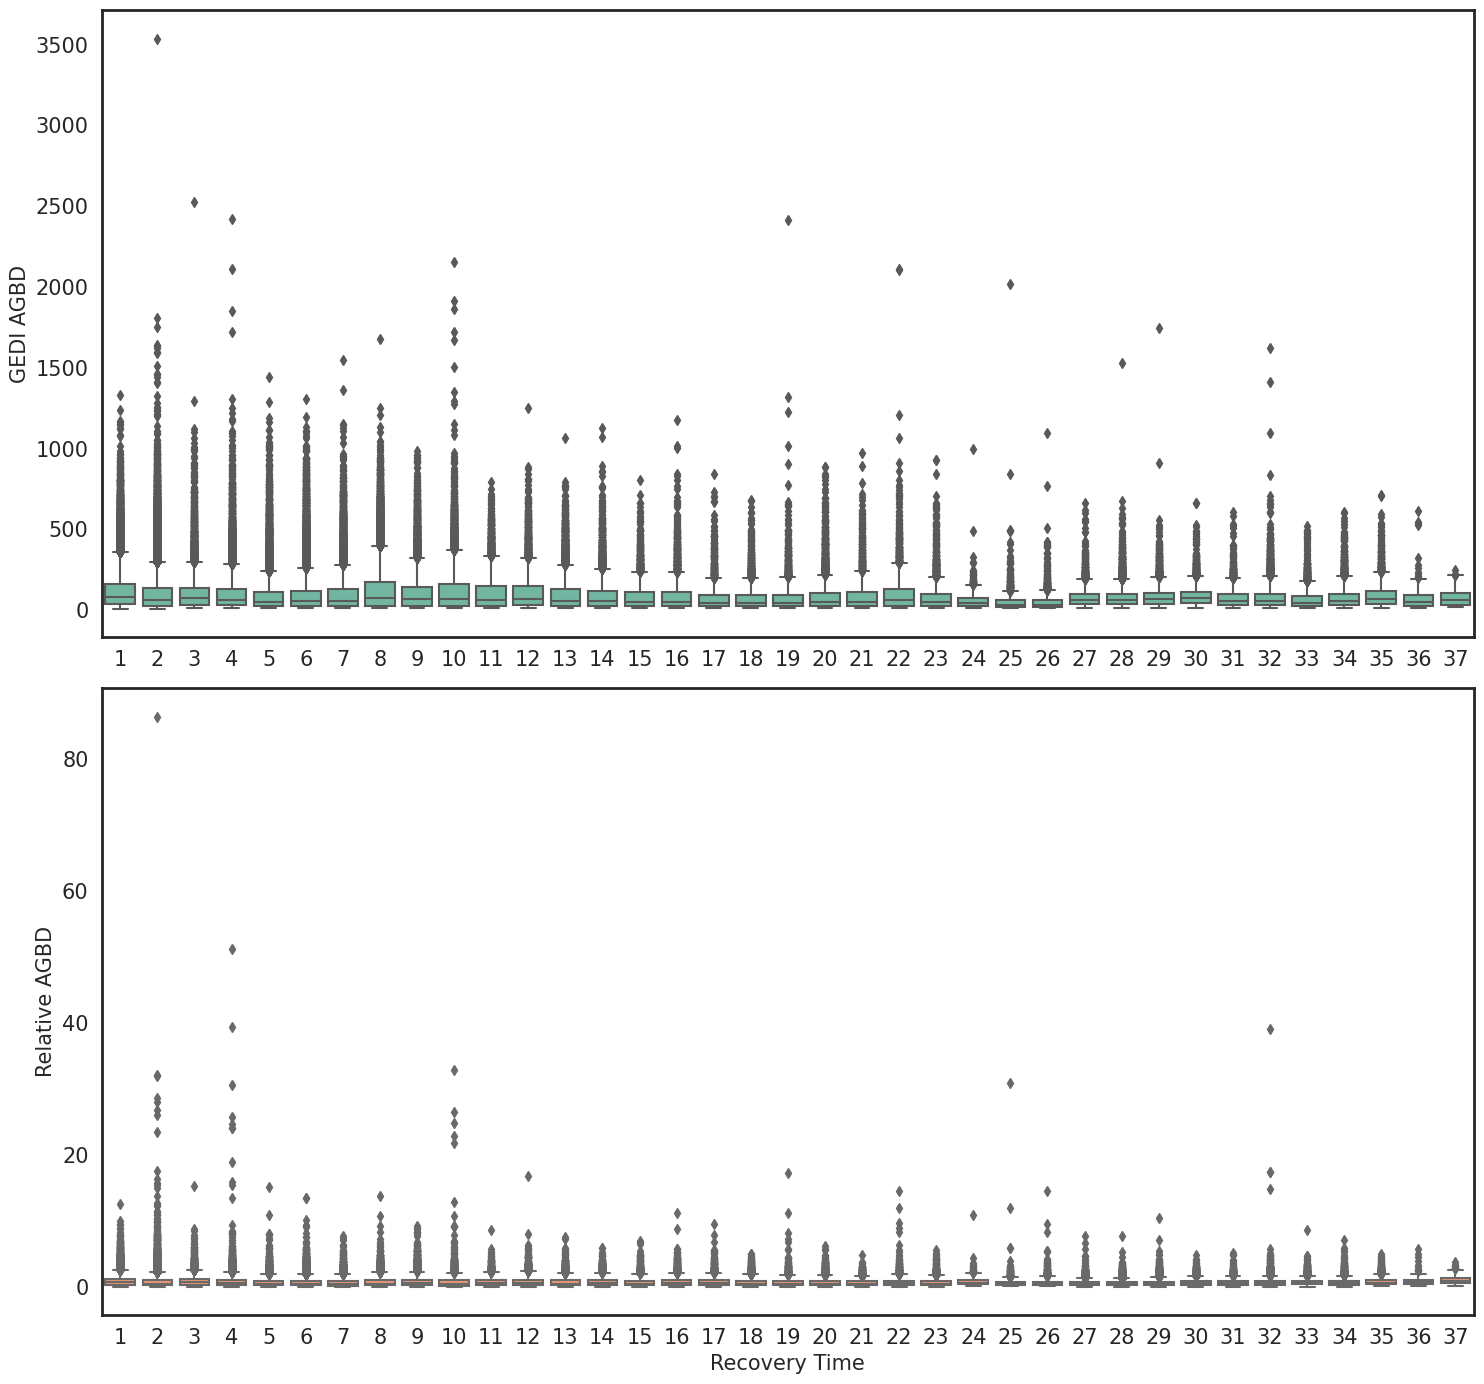

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(15, 14))
sns.boxplot(gedi_recovery, x='time_since_burn', y='agbd', ax=ax[0], color=palette[0])
sns.boxplot(gedi_recovery, x='time_since_burn', y='rel_agbd', ax=ax[1], color=palette[1])
ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("Recovery Time", fontsize=15)

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("GEDI AGBD", fontsize=15)
ax[1].set_ylabel("Relative AGBD", fontsize=15)

fig.tight_layout()
#ax.set_ylim((0, 1.5))

In [71]:
polynomial_features= PolynomialFeatures(degree=2)
medians = gedi_recovery.groupby("time_since_burn").median(numeric_only=True).rel_agbd

x = np.reshape(range(0, 37), (37, 1))
y = np.reshape(medians.to_numpy(), (37, 1))
print(x.shape)
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

ypred.shape
_, upper,lower = wls_prediction_std(model)
print(model.summary())

(37, 1)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.419
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     12.28
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           9.67e-05
Time:                        15:38:25   Log-Likelihood:                 48.649
No. Observations:                  37   AIC:                            -91.30
Df Residuals:                      34   BIC:                            -86.46
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6354      0.032     20.044 

In [90]:
ypred.shape

(37,)

In [106]:
palette = sns.color_palette("Set2")
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


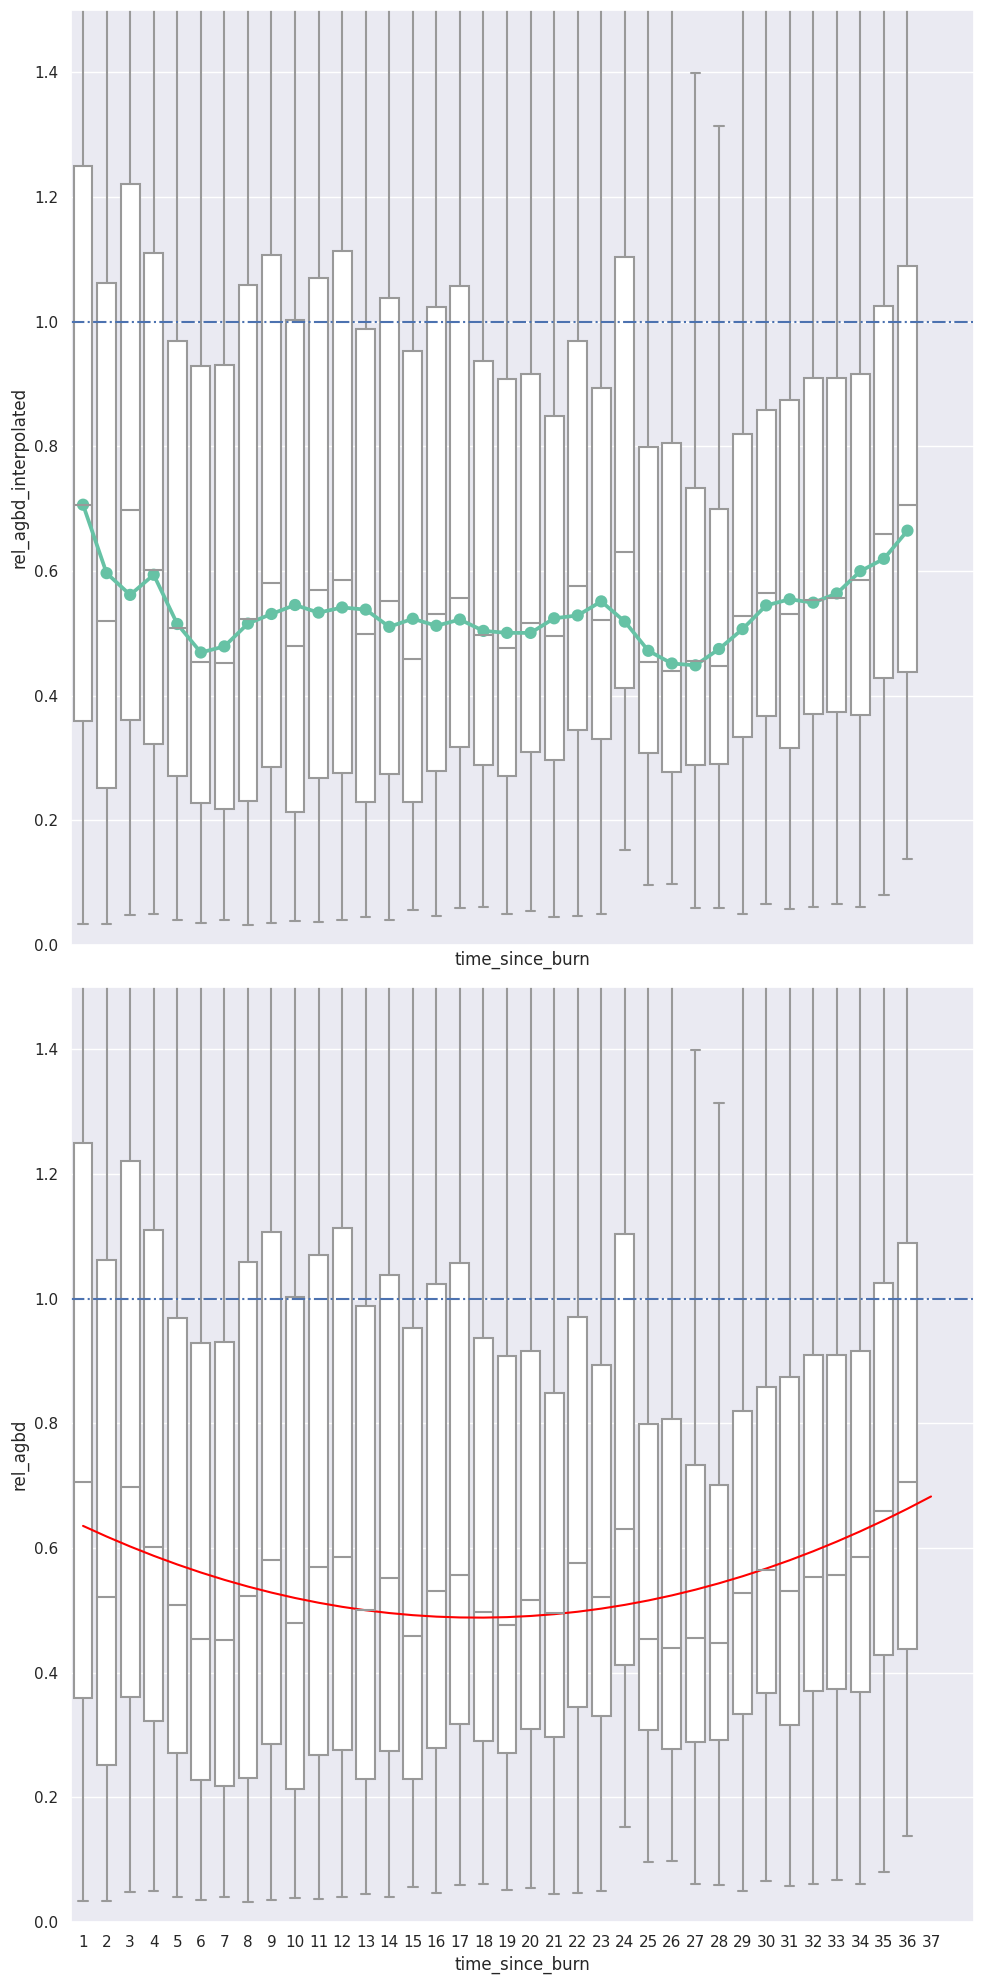

In [116]:
fig, ax = plt.subplots(2, 1, figsize=(10, 20), sharex=True, sharey=True)
sns.boxplot(x="time_since_burn", y="rel_agbd", data=gedi_recovery, color="white", showfliers=False, order=np.arange(1, 37), ax=ax[0])
sns.boxplot(x="time_since_burn", y="rel_agbd", data=gedi_recovery, color="white", showfliers=False, order=np.arange(1, 37), ax=ax[1])


ax[0].axhline(y=1, linestyle="-.")
ax[1].axhline(y=1, linestyle="-.")

sns.pointplot(agbd_interpolated, x='time_since_burn', y='rel_agbd_interpolated', estimator='median', ax=ax[0], color=palette[0])
#ax.set_ylabel("Relative AGBD", fontsize=12)
#3a.set_xlabel("Time Since Burn (years)", fontsize=12)
#ax.set_xlim([-1, 36])
#xs = np.arange(0, 36)
#ax.set_xticklabels(range(1, 37))
ax[0].set_ylim((0,1.5))

#ax.set_title("Postfire Recovery in High Severity Burn Areas")


sns.lineplot(x=range(0, 37), y=ypred, color='red', ax=ax[1])
fig.tight_layout()

### Bucket the data

In [14]:
gedi_recovery_5 = gedi_pipeline.add_time_since_burn_categories_5(gedi_recovery)
gedi_recovery_3 = gedi_pipeline.add_time_since_burn_categories_3(gedi_recovery)
gedi_recovery_10 = gedi_pipeline.add_time_since_burn_categories_10(gedi_recovery)
gedi_recovery_7 = gedi_pipeline.add_time_since_burn_categories_7(gedi_recovery)

<Axes: xlabel='time_since_burn_cat_5', ylabel='rel_agbd'>

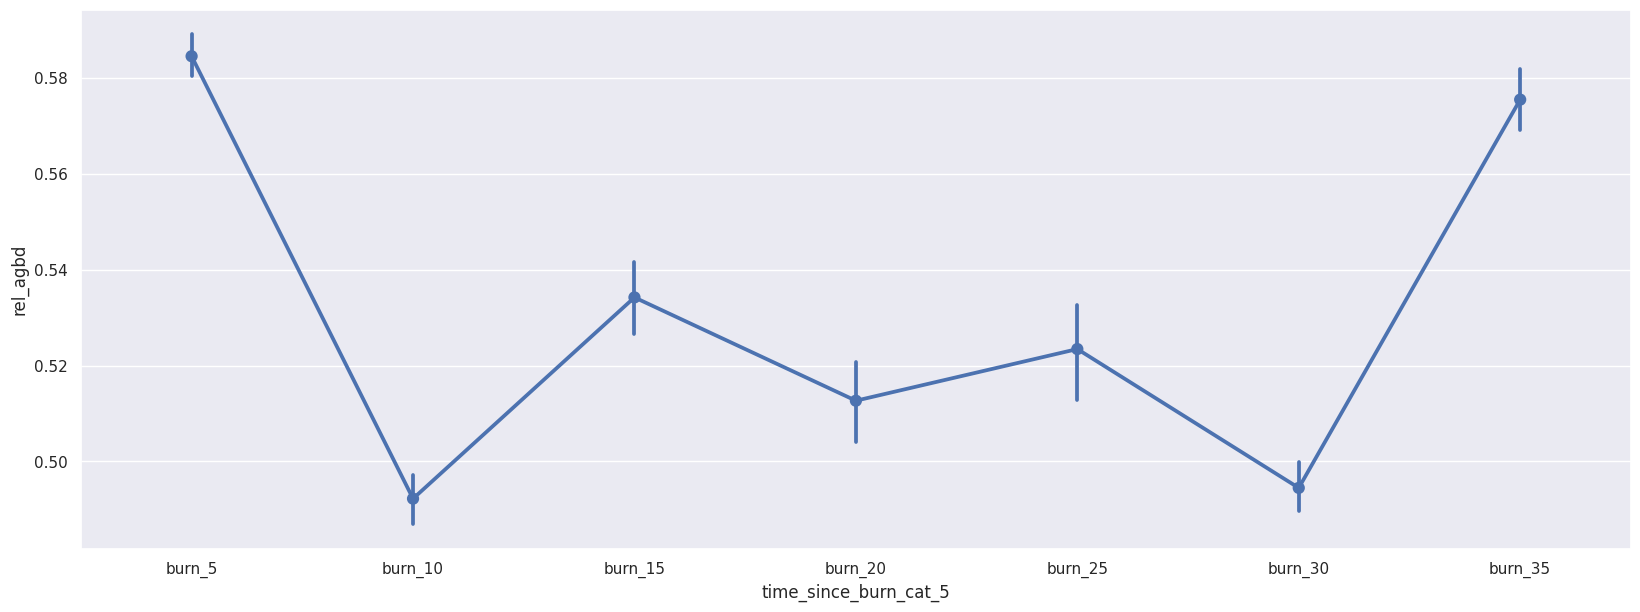

In [54]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.pointplot(gedi_recovery_5, x='time_since_burn_cat_5', y='rel_agbd', estimator='median', ax=ax)

<Axes: xlabel='time_since_burn_cat_7', ylabel='rel_agbd'>

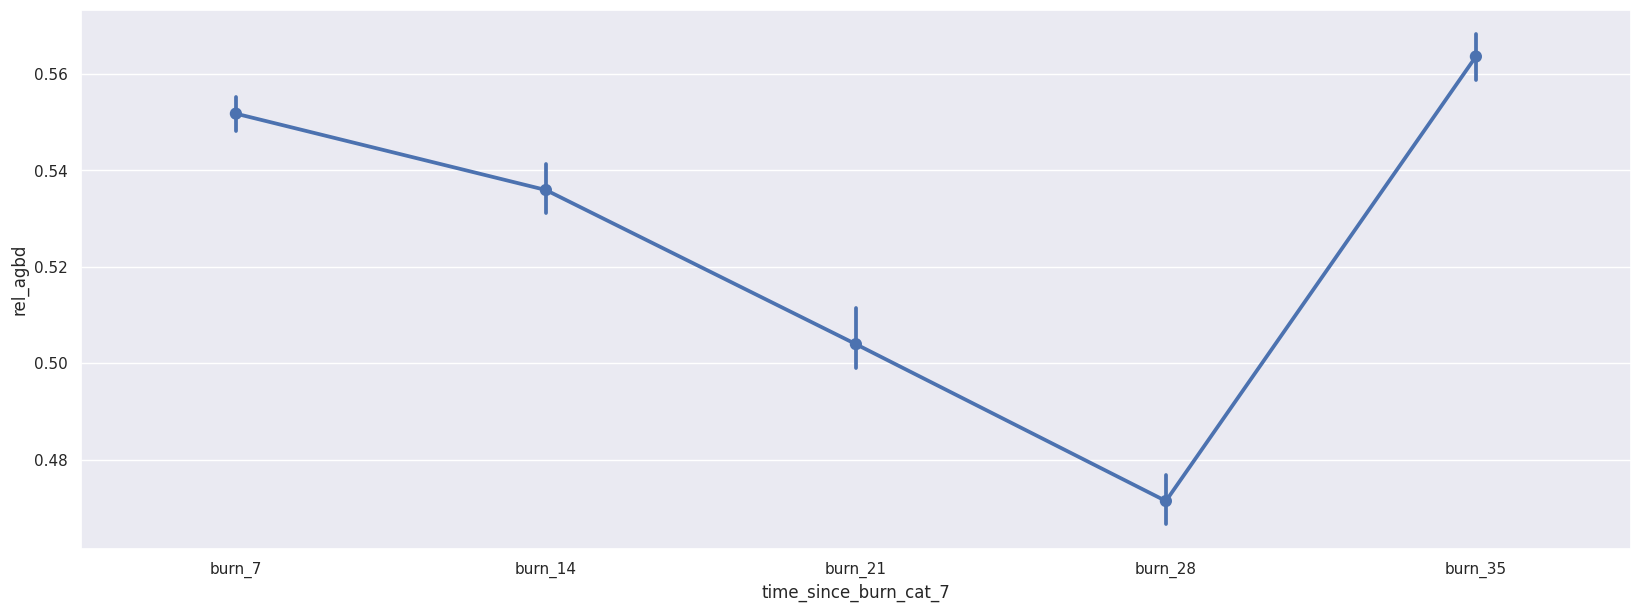

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.pointplot(gedi_recovery_7, x='time_since_burn_cat_7', y='rel_agbd', estimator='median', ax=ax)

<Axes: xlabel='time_since_burn_cat_7', ylabel='rel_agbd'>

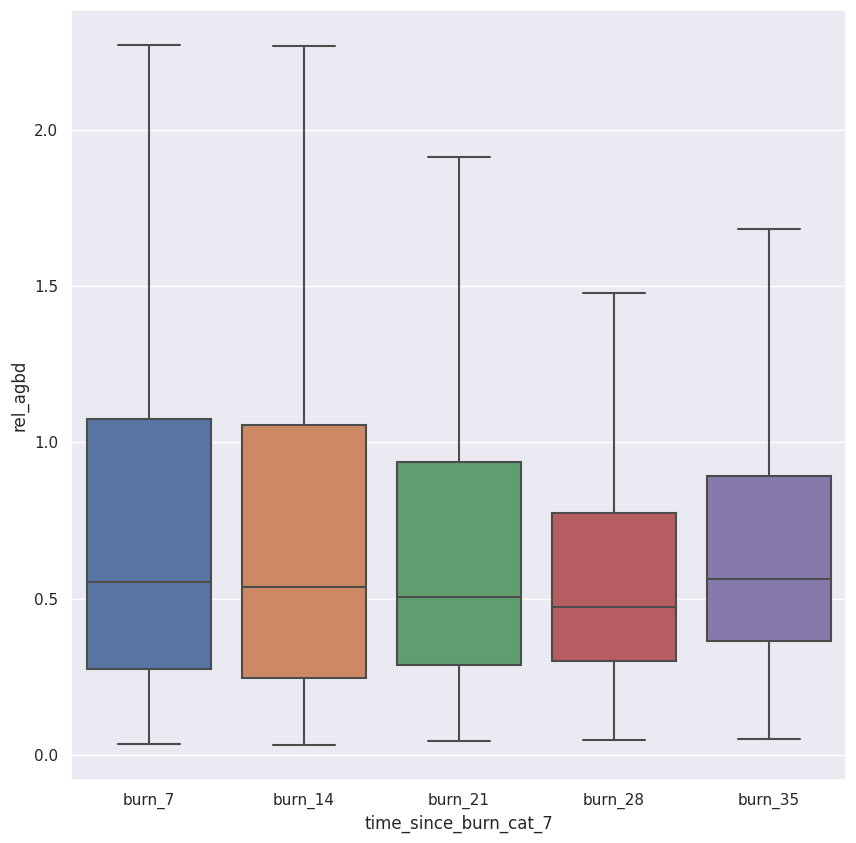

In [119]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.boxplot(gedi_recovery_7, x='time_since_burn_cat_7', y='rel_agbd',  ax=ax, showfliers=False)

<Axes: xlabel='time_since_burn', ylabel='rel_agbd'>

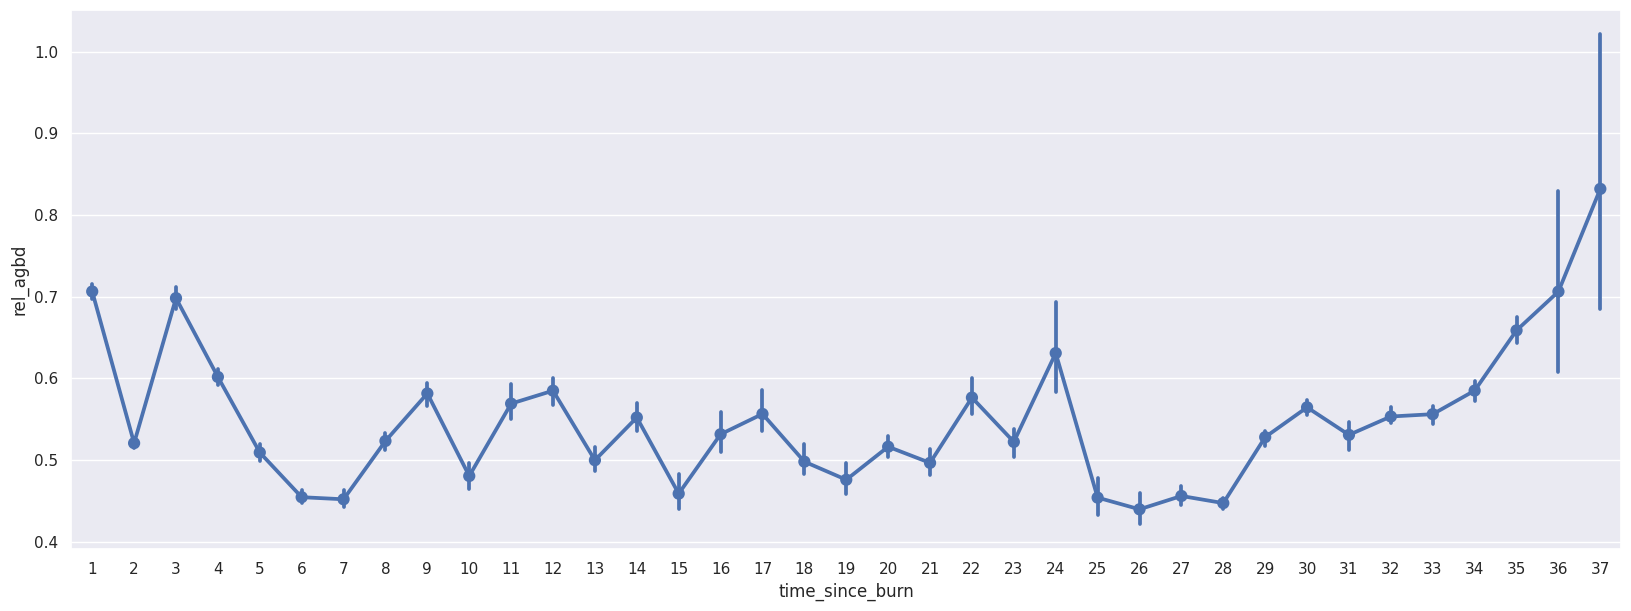

In [57]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.pointplot(gedi_recovery, x='time_since_burn', y='rel_agbd', estimator='median', ax=ax)

<Axes: xlabel='time_since_burn_cat_5', ylabel='rel_agbd'>

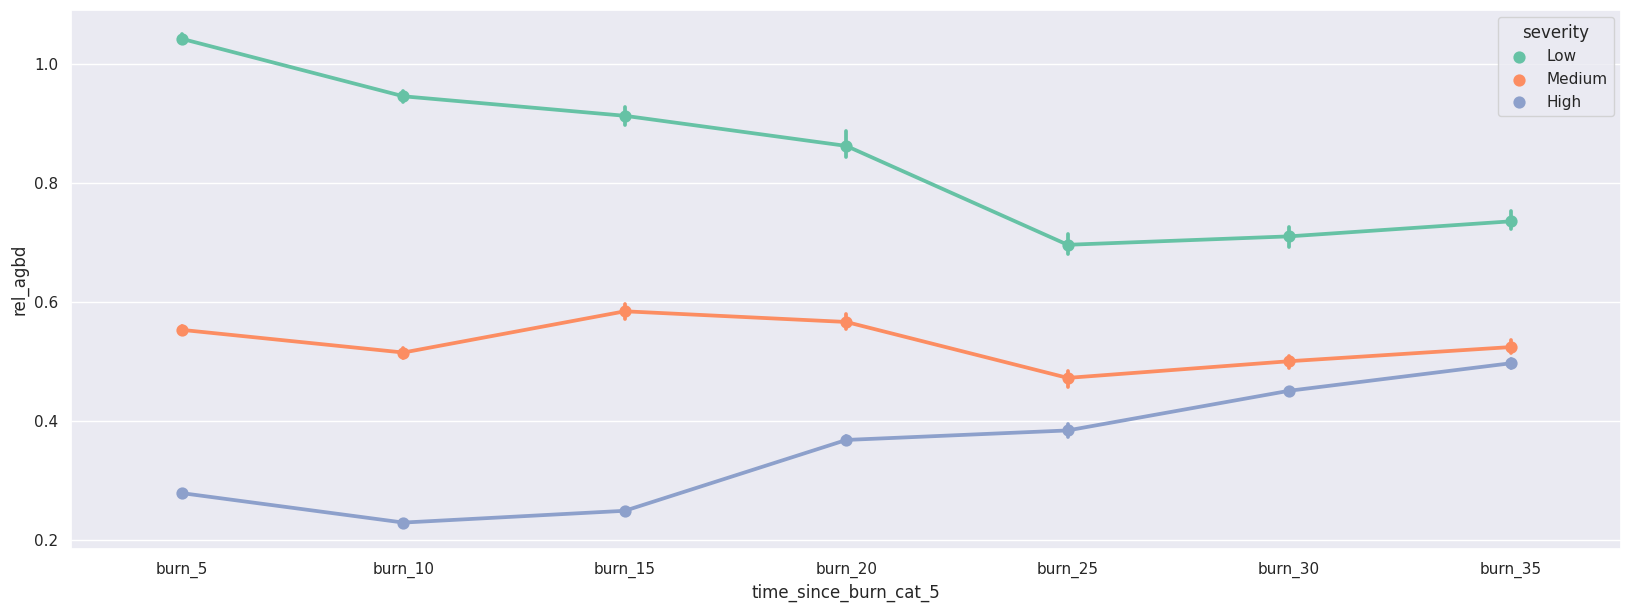

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.pointplot(gedi_recovery_5, x='time_since_burn_cat_5', y='rel_agbd', hue='severity', estimator='median', ax=ax, palette="Set2")

In [74]:
save_pickle(f"{DATA_PATH}/gedi_recovery_3.pkl", gedi_recovery_3)

<Axes: xlabel='time_since_burn_cat_3', ylabel='rel_agbd'>

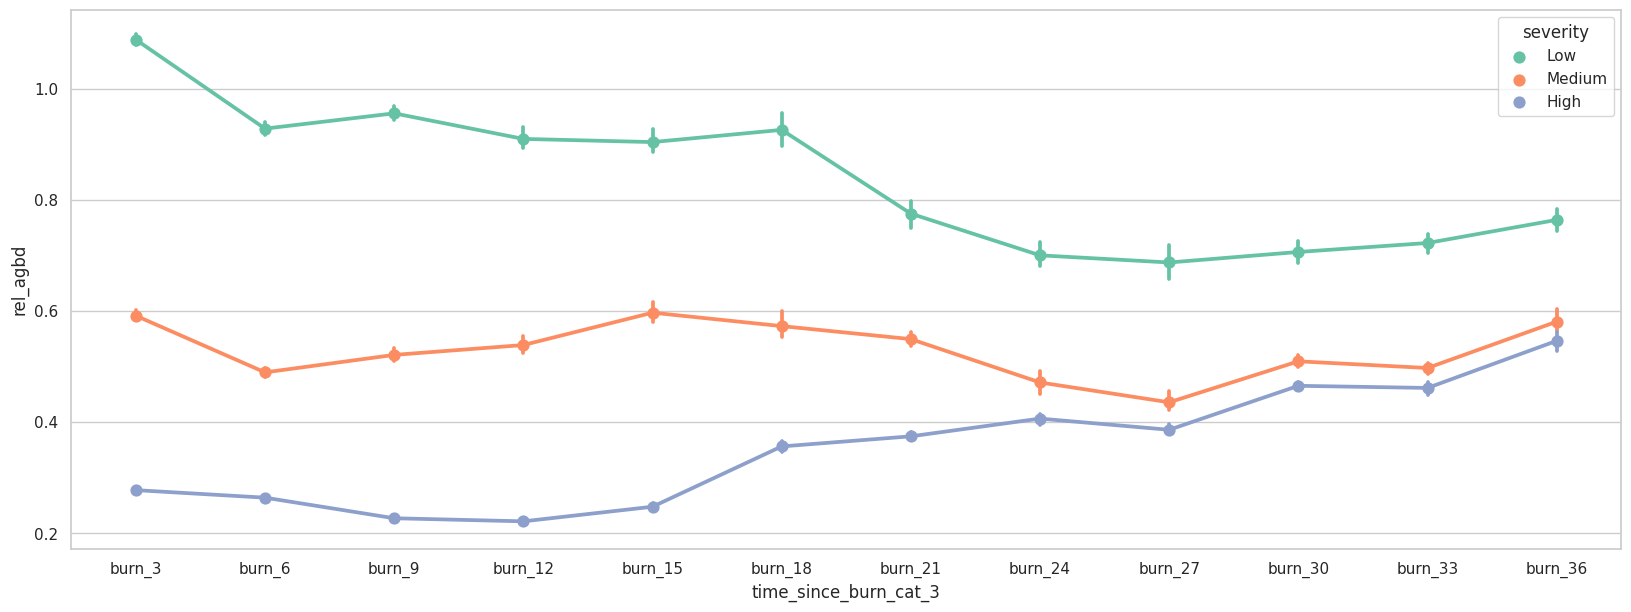

In [72]:
sns.set_theme(style="whitegrid", palette="Set2")
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.pointplot(gedi_recovery_3, x='time_since_burn_cat_3', y='rel_agbd', hue='severity', estimator='median', ax=ax, palette="Set2")

<Axes: xlabel='time_since_burn_cat_5', ylabel='rel_agbd'>

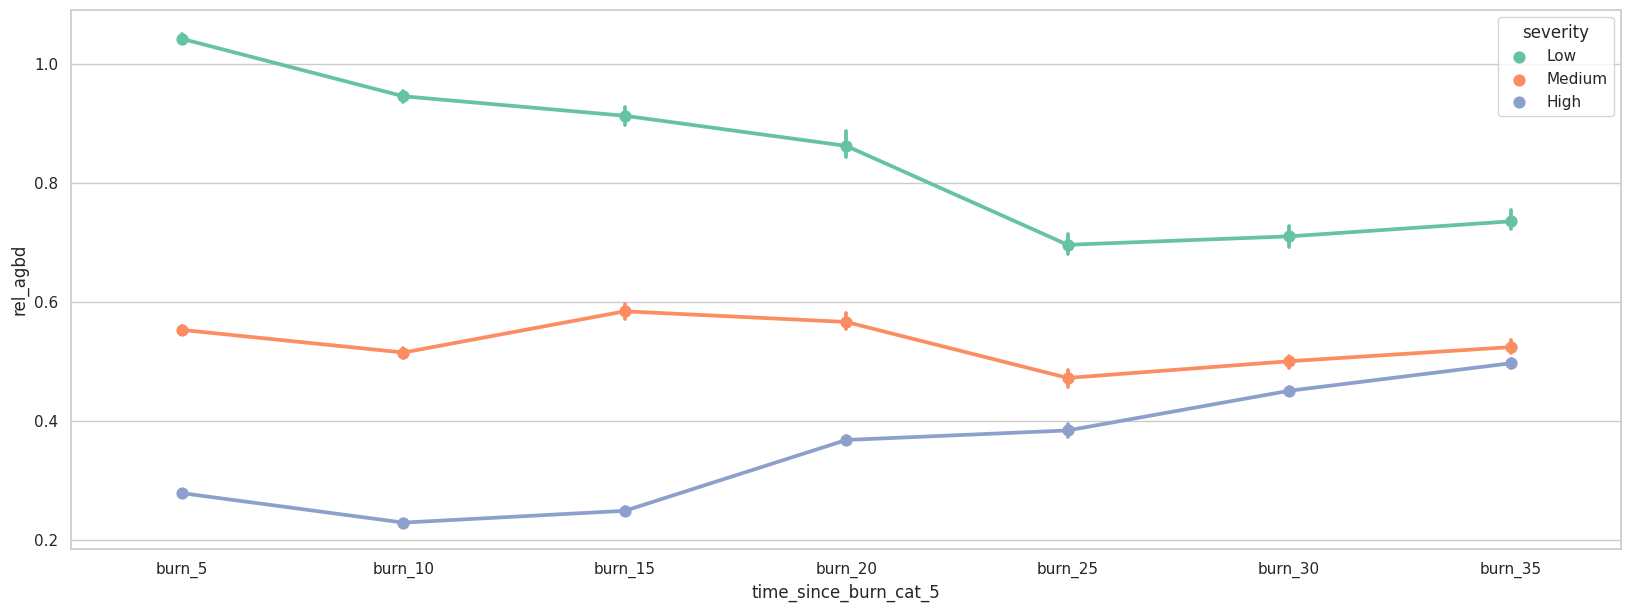

In [73]:
sns.set_theme(style="whitegrid", palette="Set2")
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.pointplot(gedi_recovery_5, x='time_since_burn_cat_5', y='rel_agbd', hue='severity', estimator='median', ax=ax, palette="Set2")

In [86]:
def fit_polynomial(to_fit):
    polynomial_features= PolynomialFeatures(degree=2)
    to_fit['time_since_burn_cat_3'].replace(['burn_3', 'burn_6', 'burn_9',
                    "burn_12", "burn_15", "burn_18", "burn_21",
                    "burn_24", "burn_27", "burn_30", "burn_33", "burn_36"],
                            range(0, 12), inplace=True)
    medians = to_fit.groupby("time_since_burn_cat_3").median(numeric_only=True).rel_agbd

    x = np.reshape(range(0, 12), (12, 1))
    y = np.reshape(medians.to_numpy(), (12, 1))
    print(x.shape)
    xp = polynomial_features.fit_transform(x)

    model = sm.OLS(y, xp).fit()
    ypred = model.predict(xp)

    ypred.shape
    _, upper,lower = wls_prediction_std(model)
    print(model.summary())
    return to_fit, ypred

def plot_boxplot_with_fit(df, fit):
    plt.figure(1, (10,10))
    ax = sns.boxplot(x="time_since_burn_cat_3", y="rel_agbd", data=df, color='white', showfliers=False, order=np.arange(12))
    ax.set_ylabel("Relative AGBD", fontsize=12)
    ax.set_xlabel("Time Since Burn (years)", fontsize=12)
    ax.set_xlim([-1, 12])
    xs = np.arange(0, 11)
    ax.set_xticklabels(range(3, 39, 3))
    # cmap = plt.get_cmap('inferno')
    get_ys = lambda a, b: a + b * xs
    ax.set_title("Postfire Recovery in High Severity Burn Areas")


    sns.lineplot(x=range(0, 12), y=fit, color='red', ax=ax)

    ax.legend(facecolor='white')

(12, 1)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     4.172
Date:                Sat, 01 Jul 2023   Prob (F-statistic):             0.0522
Time:                        02:24:06   Log-Likelihood:                 24.862
No. Observations:                  12   AIC:                            -43.72
Df Residuals:                       9   BIC:                            -42.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5786      0.026     22.238 

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<Axes: xlabel='Time Since Burn (years)', ylabel='Relative AGBD'>

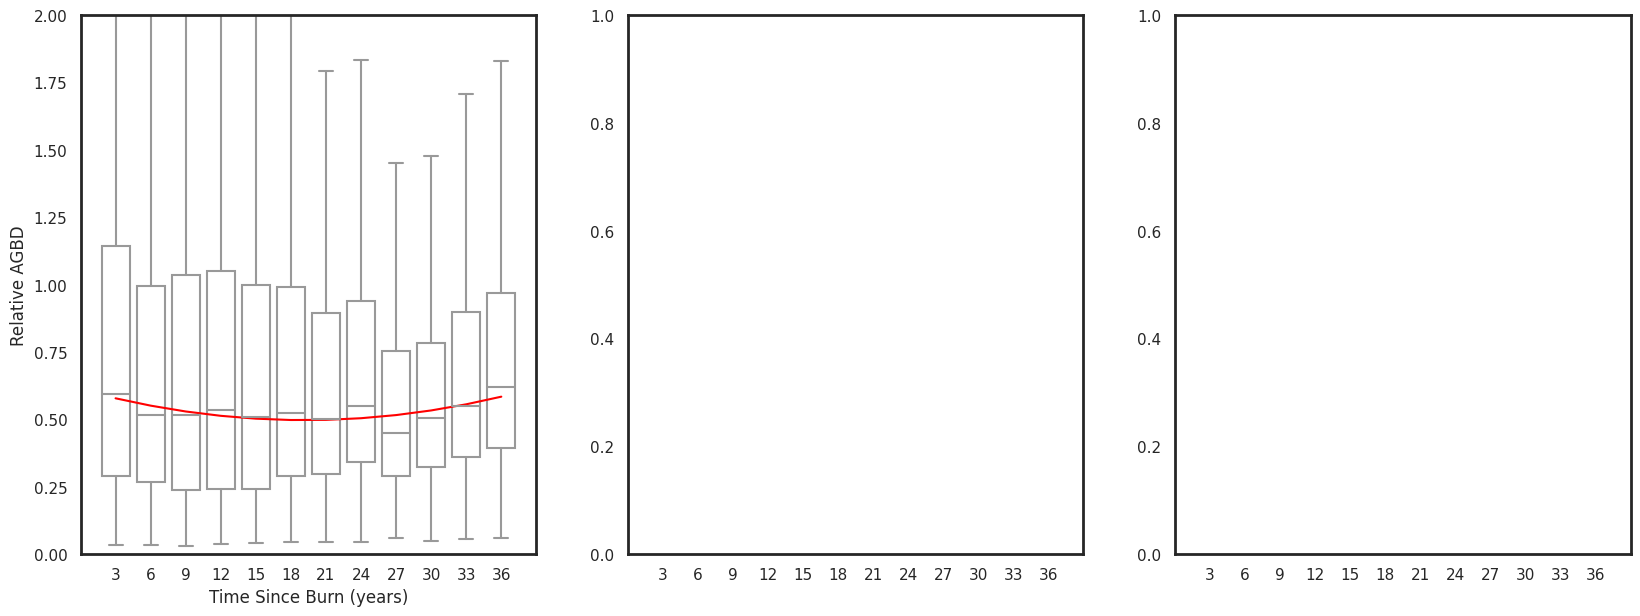

In [87]:
df_low, fit_low = fit_polynomial(gedi_recovery_3)
#df_medium, fit_medium = fit_polynomial(gedi_recovery_3, "Medium")
#df_high, fit_high = fit_polynomial(gedi_recovery_3, "High")

fig, ax = plt.subplots(1, 3, figsize=(20, 7), sharex=True)

sns.boxplot(x="time_since_burn_cat_3", y="rel_agbd", data=df_low, color='white', showfliers=False, order=np.arange(12), ax=ax[0])
ax[0].set_ylabel("Relative AGBD", fontsize=12)
ax[0].set_xlabel("Time Since Burn (years)", fontsize=12)
ax[0].set_xlim([-1, 12])
xs = np.arange(0, 11)
ax[0].set_xticklabels(range(3, 39, 3))
ax[0].set_ylim((0,2))
# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
#ax.set_title("Postfire Recovery in High Severity Burn Areas")


sns.lineplot(x=range(0, 12), y=fit_low, color='red', ax=ax[0])

#ax.legend(facecolor='white')

(12, 1)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     39.40
Date:                Sat, 01 Jul 2023   Prob (F-statistic):           3.53e-05
Time:                        02:28:25   Log-Likelihood:                 24.072
No. Observations:                  12   AIC:                            -42.14
Df Residuals:                       9   BIC:                            -40.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2471      0.028      8.891 

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<Axes: xlabel='Time Since Burn (years)', ylabel='Relative AGBD'>

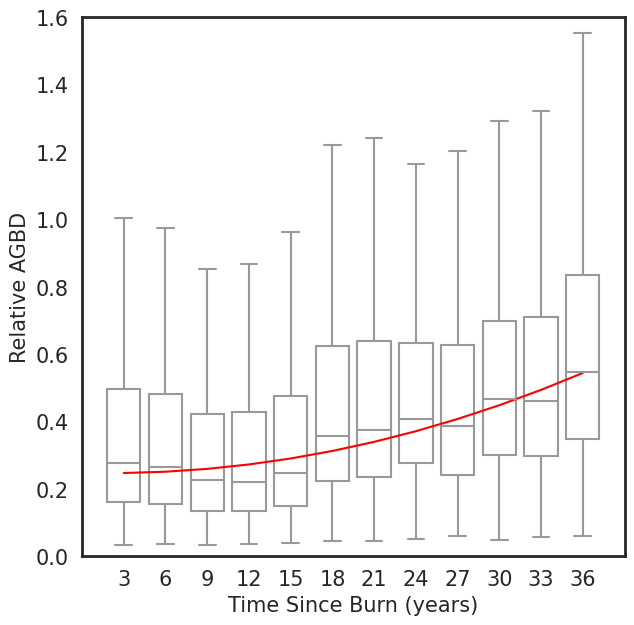

In [93]:
df_low, fit_low = fit_polynomial(gedi_recovery_3[gedi_recovery_3.severity=="High"])
#df_medium, fit_medium = fit_polynomial(gedi_recovery_3, "Medium")
#df_high, fit_high = fit_polynomial(gedi_recovery_3, "High")

fig, ax = plt.subplots(1, 1, figsize=(7, 7), sharex=True)

sns.boxplot(x="time_since_burn_cat_3", y="rel_agbd", data=df_low, color='white', showfliers=False, order=np.arange(12), ax=ax)
ax.set_ylabel("Relative AGBD", fontsize=15)
ax.set_xlabel("Time Since Burn (years)", fontsize=15)
ax.set_xlim([-1, 12])
xs = np.arange(0, 11)
ax.set_xticklabels(range(3, 39, 3))
ax.set_ylim((0,1.6))
ax.tick_params(axis='both', which='major', labelsize=15)


sns.lineplot(x=range(0, 12), y=fit_low, color='red', ax=ax)

#ax.legend(facecolor='white')

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(12, 1)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.481
Model:                            OLS   Adj. R-squared:                  0.366
Method:                 Least Squares   F-statistic:                     4.172
Date:                Thu, 29 Jun 2023   Prob (F-statistic):             0.0522
Time:                        15:22:19   Log-Likelihood:                 24.862
No. Observations:                  12   AIC:                            -43.72
Df Residuals:                       9   BIC:                            -42.27
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5786      0.026     22.238 

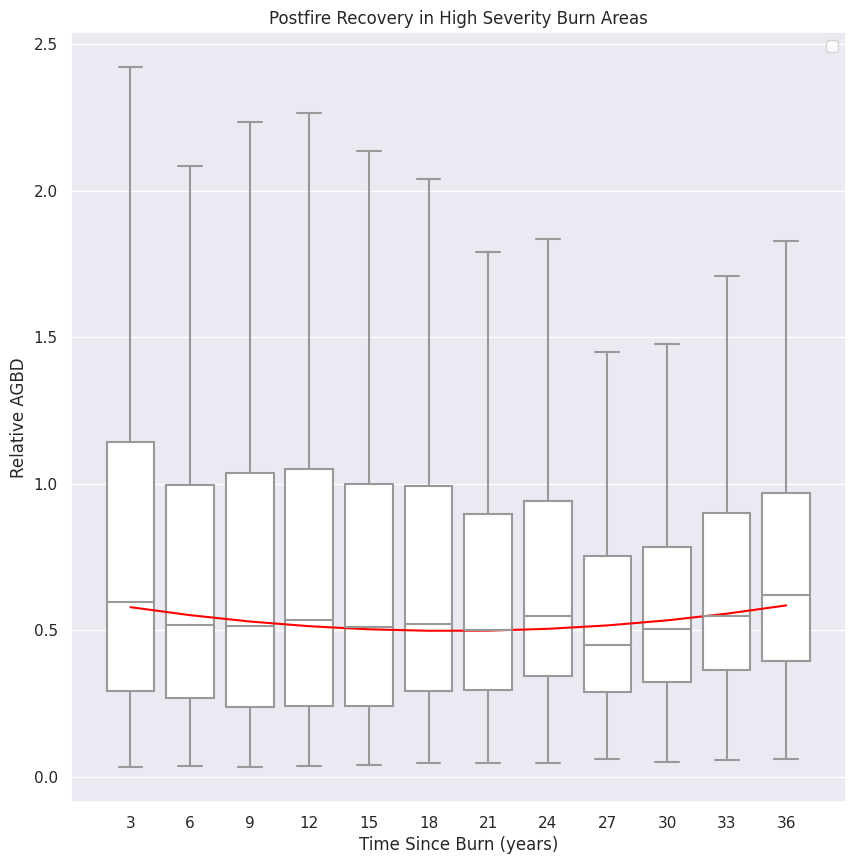

In [53]:
df, fit = fit_polynomial(gedi_recovery_3)
plot_boxplot_with_fit(df, fit)

(12, 1)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     39.40
Date:                Thu, 29 Jun 2023   Prob (F-statistic):           3.53e-05
Time:                        15:06:43   Log-Likelihood:                 24.072
No. Observations:                  12   AIC:                            -42.14
Df Residuals:                       9   BIC:                            -40.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2471      0.028      8.891 

/maps-priv/maps/fire-regen/fire-regen-env/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=12
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


<Axes: xlabel='time_since_burn_cat_3', ylabel='rel_agbd'>

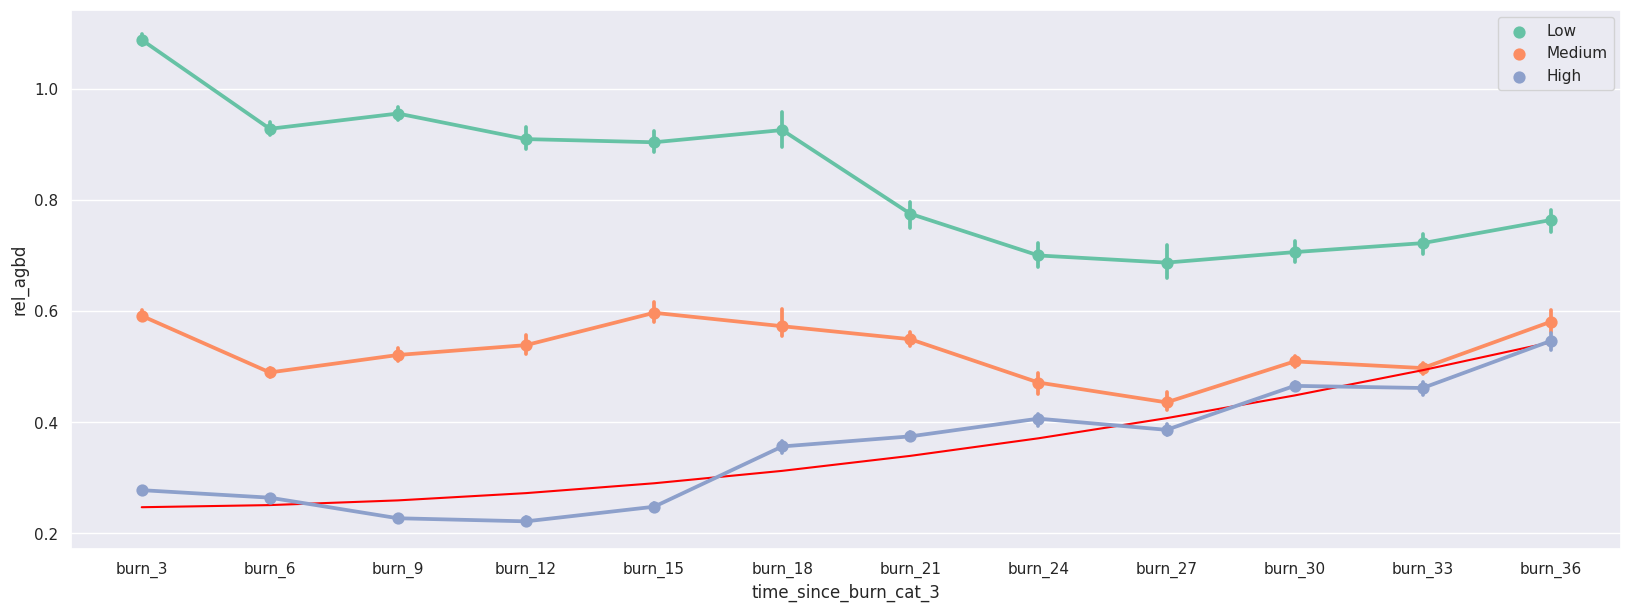

In [38]:
to_fit, ypred = fit_polynomial(gedi_recovery_3, "High")
fig, ax = plt.subplots(1, 1, figsize=(20, 7))
sns.pointplot(gedi_recovery_3, x='time_since_burn_cat_3', y='rel_agbd', hue='severity', estimator='median', ax=ax, palette="Set2")
sns.lineplot(x=range(0, 12), y=ypred, color='red', ax=ax)
#plot_boxplot_with_fit(to_fit, ypred)

### Fit polynomial

In [82]:
interpolated = agbd_interpolated[agbd_interpolated.time_since_burn < 36]

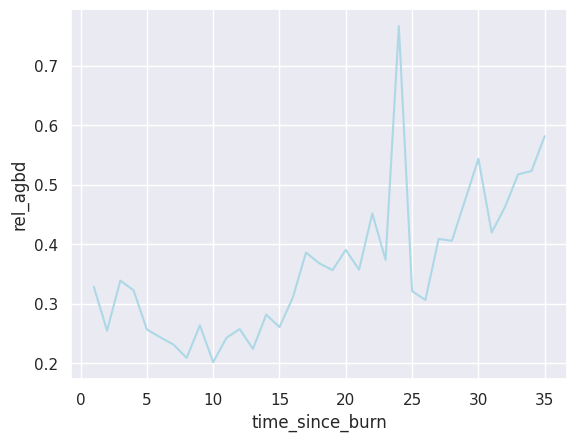

In [31]:
ax = sns.lineplot(x="time_since_burn", y="rel_agbd", data=to_fit, color='lightblue')

In [83]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from src.data import stats
import numpy as np
importlib.reload(stats)

polynomial_features= PolynomialFeatures(degree=2)
to_fit = interpolated[interpolated.severity == "High"].sort_values("time_since_burn")

x = np.reshape(to_fit['time_since_burn'].to_numpy(), (to_fit['time_since_burn'].to_numpy().shape[0], 1))
y = np.reshape(to_fit['rel_agbd_interpolated'].to_numpy(), (to_fit['rel_agbd_interpolated'].to_numpy().shape[0], 1))
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

ypred.shape
_, upper,lower = wls_prediction_std(model)
print(model.summary())

AttributeError: 'DataFrame' object has no attribute 'severity'

In [34]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from src.data import stats
import numpy as np
importlib.reload(stats)

polynomial_features= PolynomialFeatures(degree=2)
to_fit = interpolated[interpolated.severity == "High"].sort_values("time_since_burn")

x = np.reshape(to_fit['time_since_burn'].to_numpy(), (to_fit['time_since_burn'].to_numpy().shape[0], 1))
y = np.reshape(to_fit['rel_agbd_interpolated'].to_numpy(), (to_fit['rel_agbd_interpolated'].to_numpy().shape[0], 1))
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

ypred.shape
_, upper,lower = wls_prediction_std(model)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     116.3
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           2.08e-15
Time:                        23:35:16   Log-Likelihood:                 68.721
No. Observations:                  35   AIC:                            -131.4
Df Residuals:                      32   BIC:                            -126.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2699      0.019     14.134      0.0

In [27]:
x.shape

(35, 1)

In [29]:
to_fit.shape, xs.shape

((35, 5), (35,))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


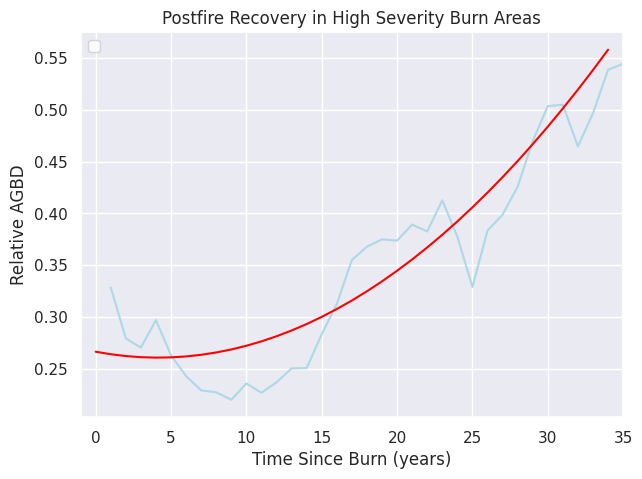

In [38]:
plt.figure(1, (7,5))
ax = sns.lineplot(x="time_since_burn", y="rel_agbd_interpolated", data=to_fit, color='lightblue')
ax.set_ylabel("Relative AGBD", fontsize=12)
ax.set_xlabel("Time Since Burn (years)", fontsize=12)
ax.set_xlim([-1, 35])
#xs = np.arange(0, 11)
xs = np.arange(0, 35)
#ax.set_xticklabels(range(0, 39, 3))
# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
ax.set_title("Postfire Recovery in High Severity Burn Areas")


sns.lineplot(x=range(0, 35), y=ypred, color='red', ax=ax)

ax.legend(facecolor='white')
#ax.set_ylim([0, ])

In [39]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from src.data import stats
import numpy as np
importlib.reload(stats)

polynomial_features= PolynomialFeatures(degree=2)
to_fit = interpolated[interpolated.severity == "Low"].sort_values("time_since_burn")

x = np.reshape(to_fit['time_since_burn'].to_numpy(), (to_fit['time_since_burn'].to_numpy().shape[0], 1))
y = np.reshape(to_fit['rel_agbd_interpolated'].to_numpy(), (to_fit['rel_agbd_interpolated'].to_numpy().shape[0], 1))
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

ypred.shape
_, upper,lower = wls_prediction_std(model)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.821
Method:                 Least Squares   F-statistic:                     78.86
Date:                Wed, 28 Jun 2023   Prob (F-statistic):           4.29e-13
Time:                        23:36:59   Log-Likelihood:                 53.705
No. Observations:                  35   AIC:                            -101.4
Df Residuals:                      32   BIC:                            -96.74
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1050      0.029     37.681      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


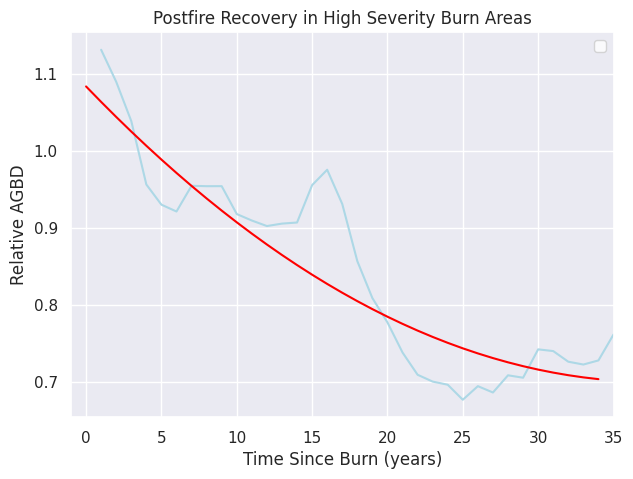

In [40]:
plt.figure(1, (7,5))
ax = sns.lineplot(x="time_since_burn", y="rel_agbd_interpolated", data=to_fit, color='lightblue')
ax.set_ylabel("Relative AGBD", fontsize=12)
ax.set_xlabel("Time Since Burn (years)", fontsize=12)
ax.set_xlim([-1, 35])
#xs = np.arange(0, 11)
xs = np.arange(0, 35)
#ax.set_xticklabels(range(0, 39, 3))
# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
ax.set_title("Postfire Recovery in High Severity Burn Areas")


sns.lineplot(x=range(0, 35), y=ypred, color='red', ax=ax)

ax.legend(facecolor='white')
#ax.set_ylim([0, ])

In [41]:
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from src.data import stats
import numpy as np
importlib.reload(stats)

polynomial_features= PolynomialFeatures(degree=2)
to_fit = interpolated[interpolated.severity == "Medium"].sort_values("time_since_burn")

x = np.reshape(to_fit['time_since_burn'].to_numpy(), (to_fit['time_since_burn'].to_numpy().shape[0], 1))
y = np.reshape(to_fit['rel_agbd_interpolated'].to_numpy(), (to_fit['rel_agbd_interpolated'].to_numpy().shape[0], 1))
xp = polynomial_features.fit_transform(x)

model = sm.OLS(y, xp).fit()
ypred = model.predict(xp)

ypred.shape
_, upper,lower = wls_prediction_std(model)
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     2.389
Date:                Wed, 28 Jun 2023   Prob (F-statistic):              0.108
Time:                        23:38:11   Log-Likelihood:                 56.844
No. Observations:                  35   AIC:                            -107.7
Df Residuals:                      32   BIC:                            -103.0
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5767      0.027     21.510      0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


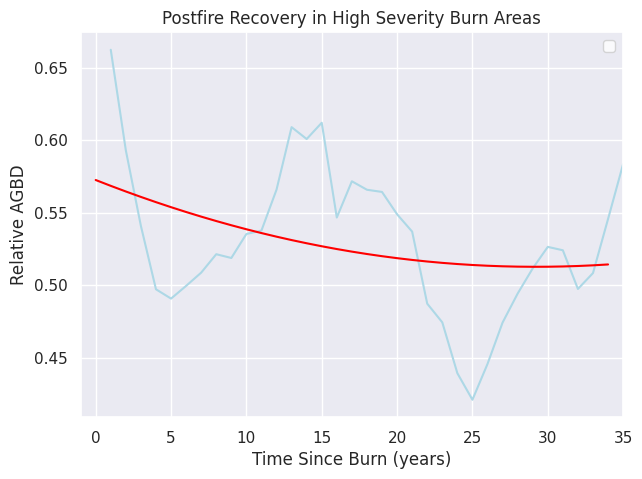

In [42]:
plt.figure(1, (7,5))
ax = sns.lineplot(x="time_since_burn", y="rel_agbd_interpolated", data=to_fit, color='lightblue')
ax.set_ylabel("Relative AGBD", fontsize=12)
ax.set_xlabel("Time Since Burn (years)", fontsize=12)
ax.set_xlim([-1, 35])
#xs = np.arange(0, 11)
xs = np.arange(0, 35)
#ax.set_xticklabels(range(0, 39, 3))
# cmap = plt.get_cmap('inferno')
get_ys = lambda a, b: a + b * xs
ax.set_title("Postfire Recovery in High Severity Burn Areas")


sns.lineplot(x=range(0, 35), y=ypred, color='red', ax=ax)

ax.legend(facecolor='white')
#ax.set_ylim([0, ])

### Plot pdf measurements

129716


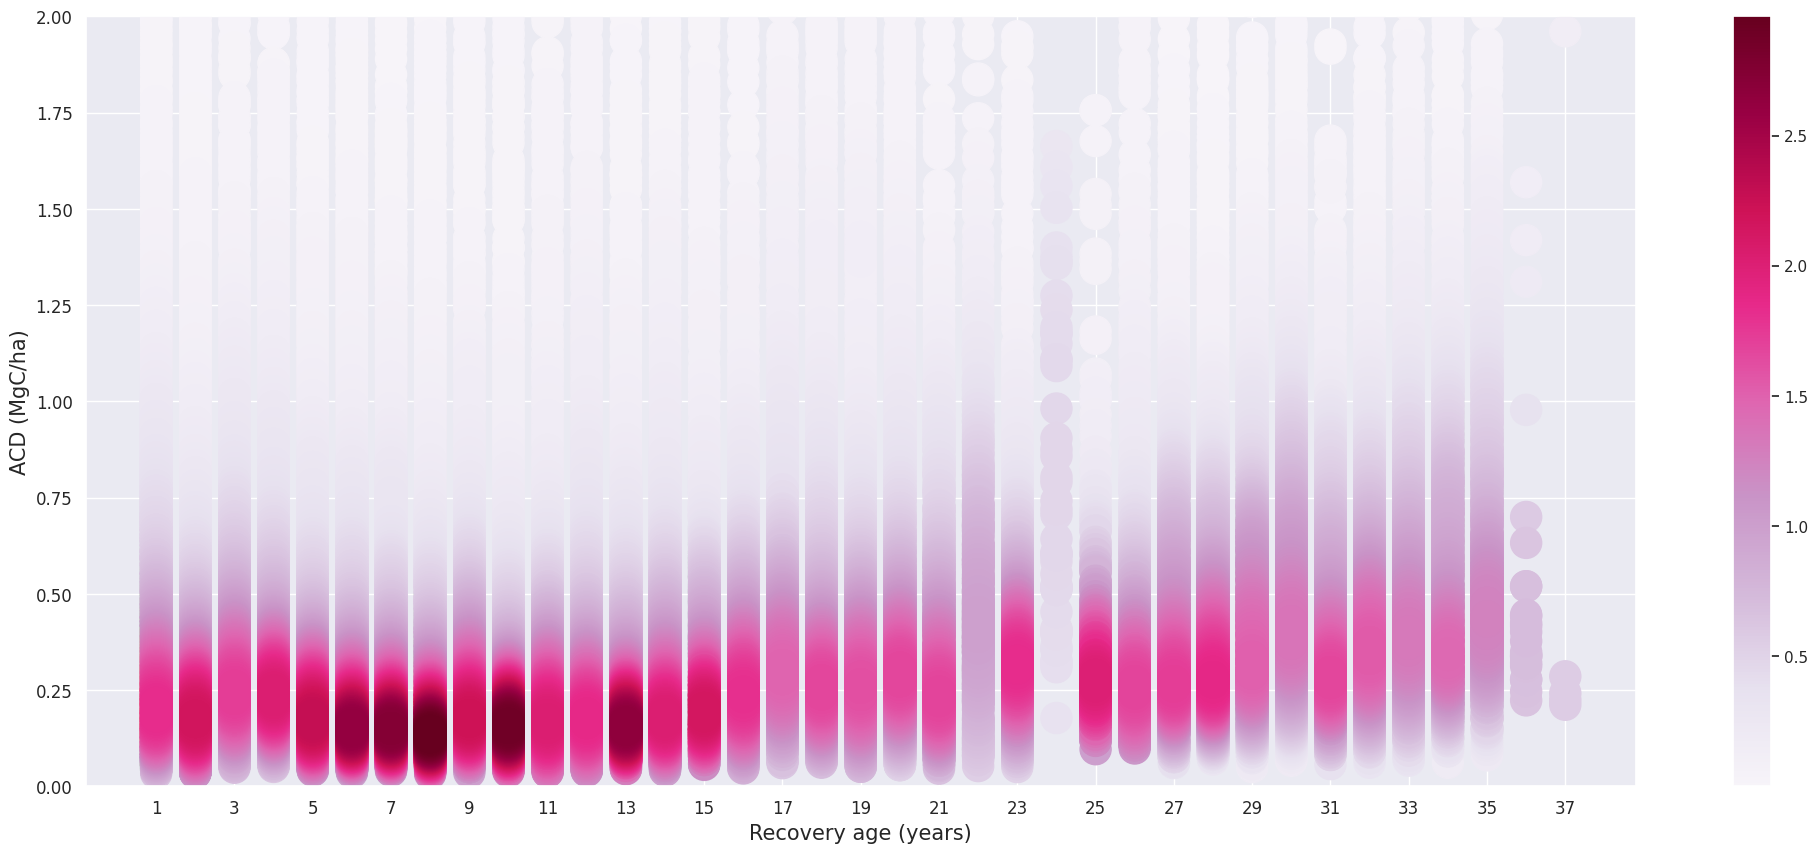

In [48]:
plot_pdf(gedi_recovery[gedi_recovery.severity == "High"],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

87660


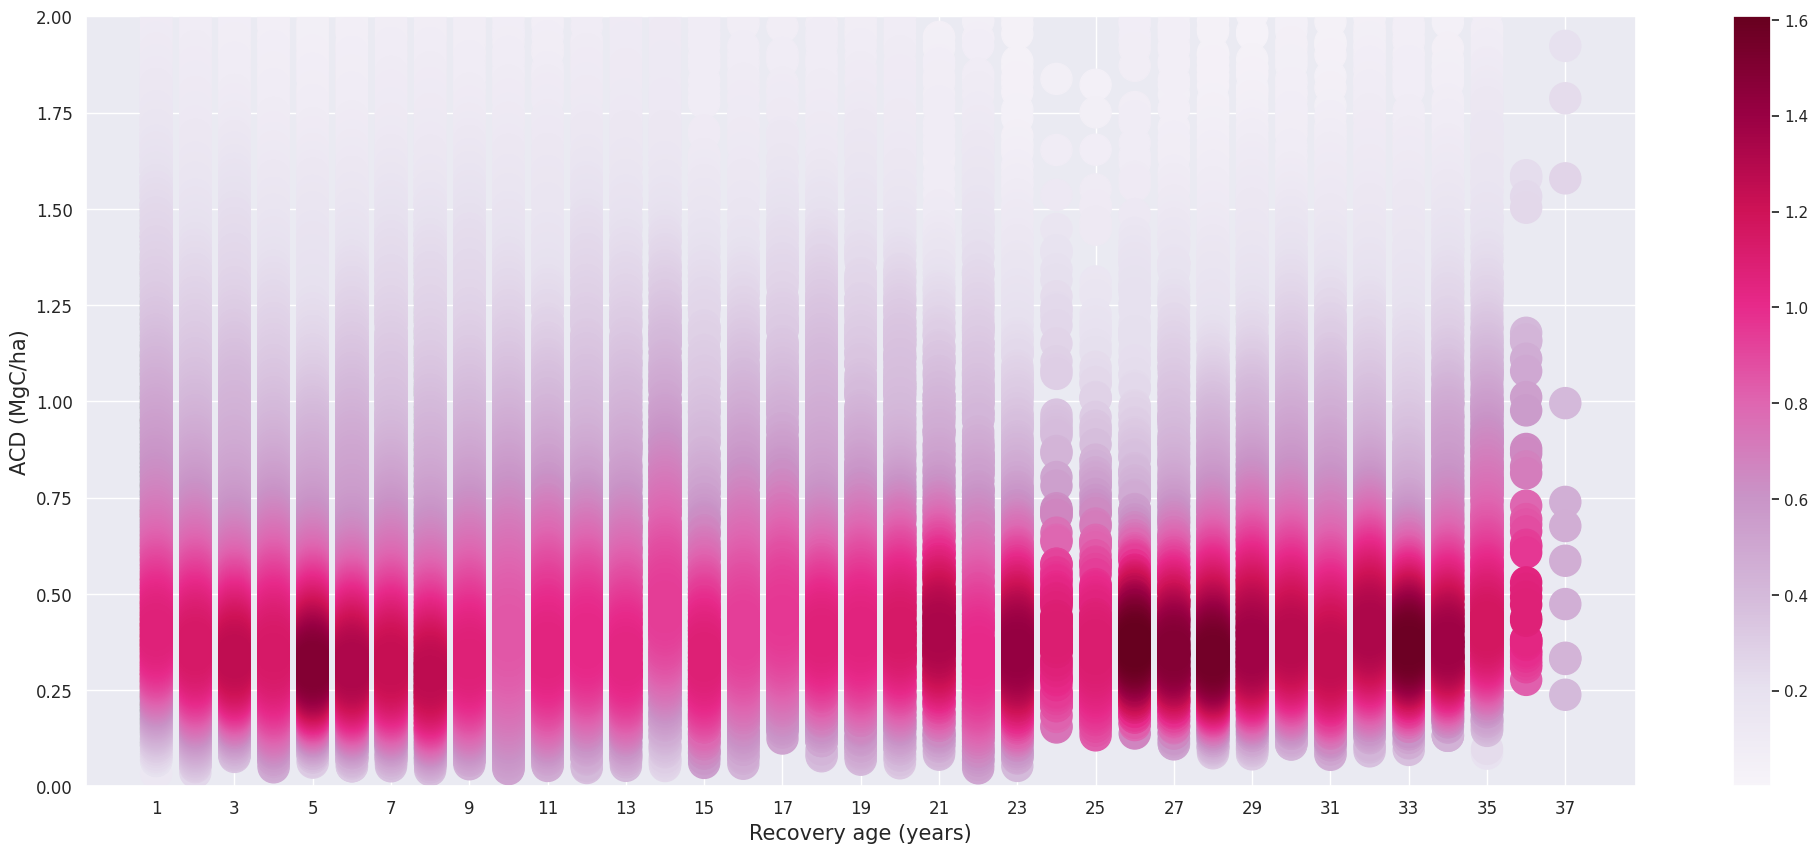

In [49]:
plot_pdf(gedi_recovery[gedi_recovery.severity == "Medium"],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

115645


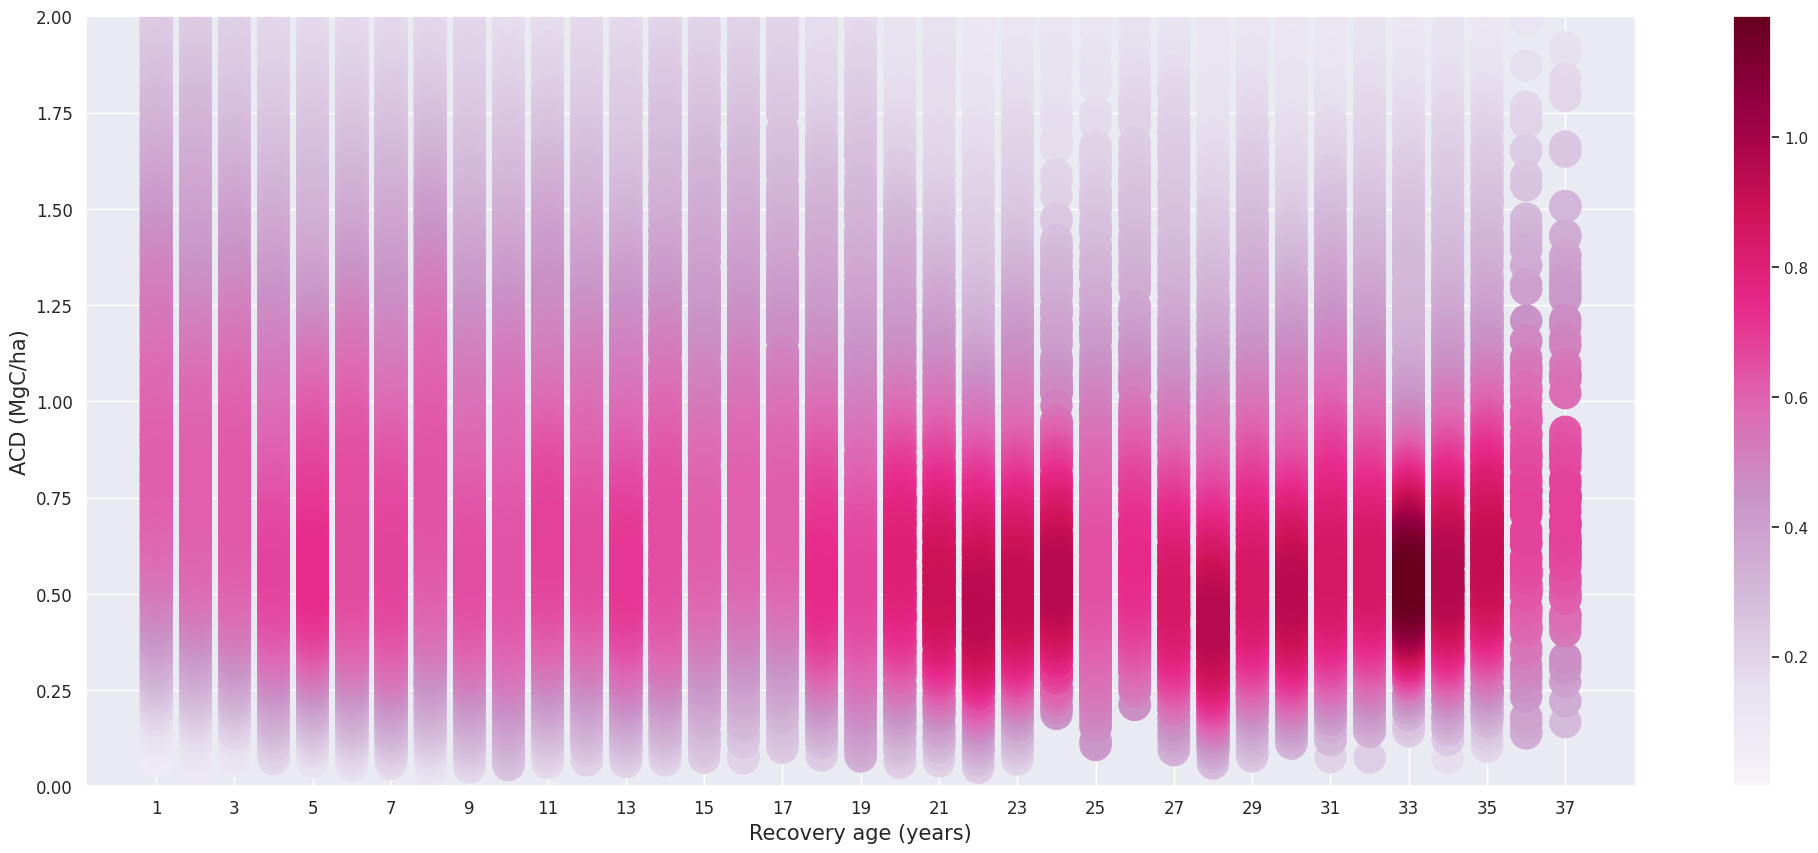

In [47]:
plot_pdf(gedi_recovery[gedi_recovery.severity == "Low"],
         'time_since_burn',
         'rel_agbd',
         "Recovery age (years)",
         "ACD (MgC/ha)",
         (0, 2))

### Density plots

In [57]:
gedi_recovery_5 = gedi_pipeline.add_time_since_burn_categories_5(gedi_recovery)
gedi_recovery_3 = gedi_pipeline.add_time_since_burn_categories_3(gedi_recovery)
gedi_recovery_10 = gedi_pipeline.add_time_since_burn_categories_10(gedi_recovery)
gedi_recovery_7 = gedi_pipeline.add_time_since_burn_categories_7(gedi_recovery)

In [62]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_recovery_10, palette=palette, row="time_since_burn_cat_10", hue="time_since_burn_cat_10", aspect=9, height=1.2, xlim=[-0.1, 3])
g.map_dataframe(sns.kdeplot, x="rel_agbd", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="rel_agbd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)
#g.refline(x=0, linestyle='dashed', ylim=[0,0.06])

#plt.suptitle('Netflix Originals - IMDB Scores by Language', y=0.98)

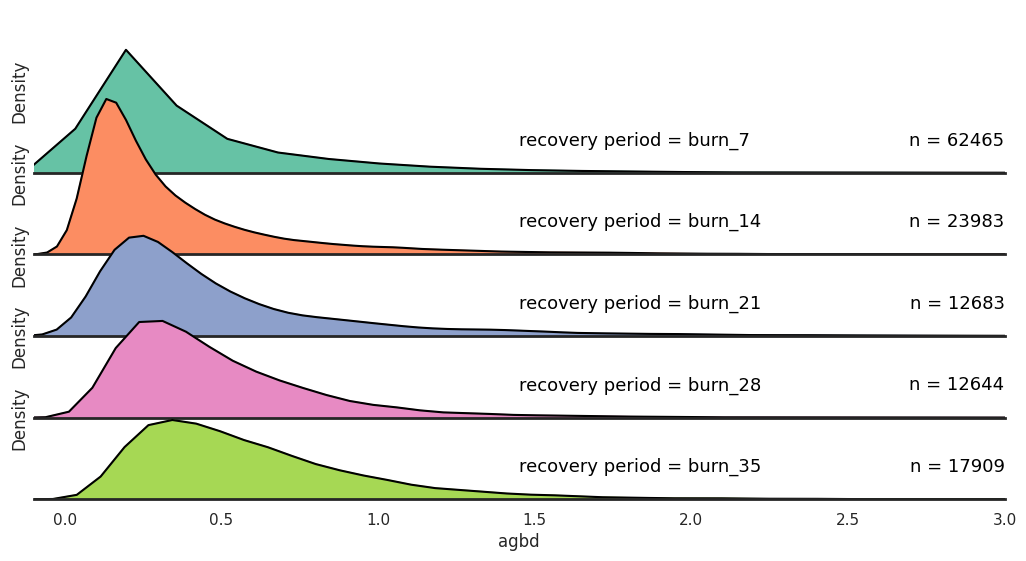

In [75]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_recovery_7[gedi_recovery_7.severity == "High"], palette=palette, row="time_since_burn_cat_7", hue="time_since_burn_cat_7", aspect=9, height=1.2, xlim=[-0.1, 3])
g.map_dataframe(sns.kdeplot, x="rel_agbd", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="rel_agbd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)
#g.refline(x=0, linestyle='dashed', ylim=[0,0.06])

#plt.suptitle('Netflix Originals - IMDB Scores by Language', y=0.98)

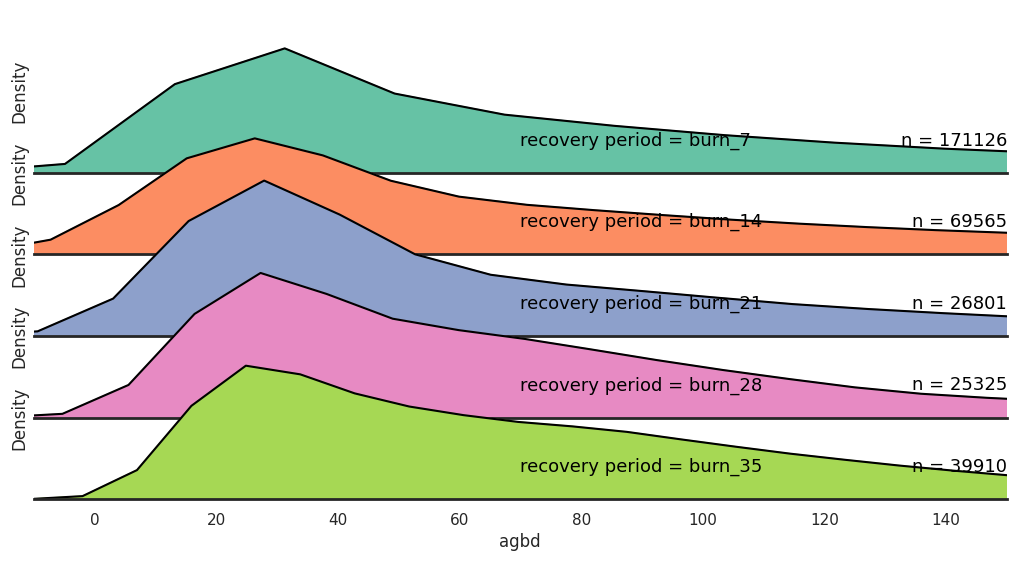

In [61]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_recovery_7, palette=palette, row="time_since_burn_cat_7", hue="time_since_burn_cat_7", aspect=9, height=1.2,  xlim=[-10,150])
g.map_dataframe(sns.kdeplot, x="agbd", fill=True, alpha=1)
g.map_dataframe(sns.kdeplot, x="agbd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)
#g.refline(x=0, linestyle='dashed', ylim=[0,0.06])

#plt.suptitle('Netflix Originals - IMDB Scores by Language', y=0.98)

In [80]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_recovery_7[gedi_recovery_7.severity=="High"], palette=palette, row="time_since_burn_cat_7", hue="time_since_burn_cat_7", aspect=9, height=1.2, xlim=[-0.1, 3])
g.map_dataframe(sns.histplot, x="rel_agbd", fill=True, alpha=1, stat='density')
#g.map_dataframe(sns.kdeplot, x="agcd", color='black')


def label(x, color, label):
    ax = plt.gca()
    lala = label[5:]
    ax.set_ylabel("")
    ax.text(0.53, .2, f'Recovery time = {int(lala) - 7}-{lala}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)

    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="Relative AGBD")
g.despine( left=True)

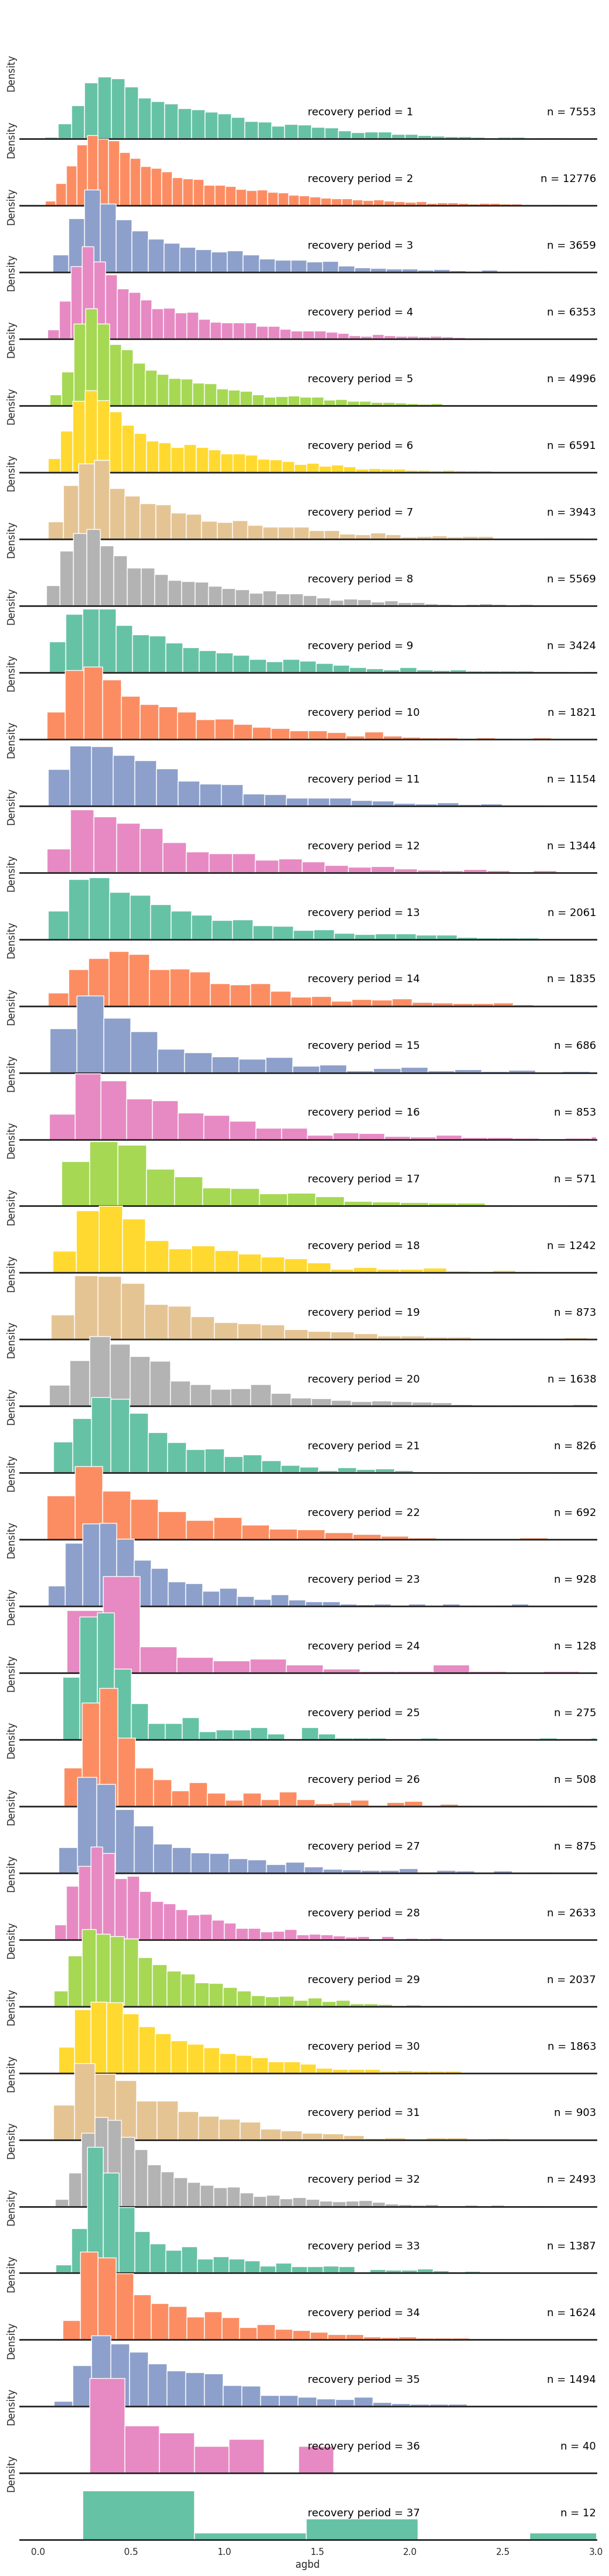

In [54]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_recovery[gedi_recovery.severity=="Medium"], palette=palette, row="time_since_burn", hue="time_since_burn", aspect=9, height=1.2, xlim=[-0.1, 3])
g.map_dataframe(sns.histplot, x="rel_agbd", fill=True, alpha=1, stat='density')
#g.map_dataframe(sns.kdeplot, x="agcd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)

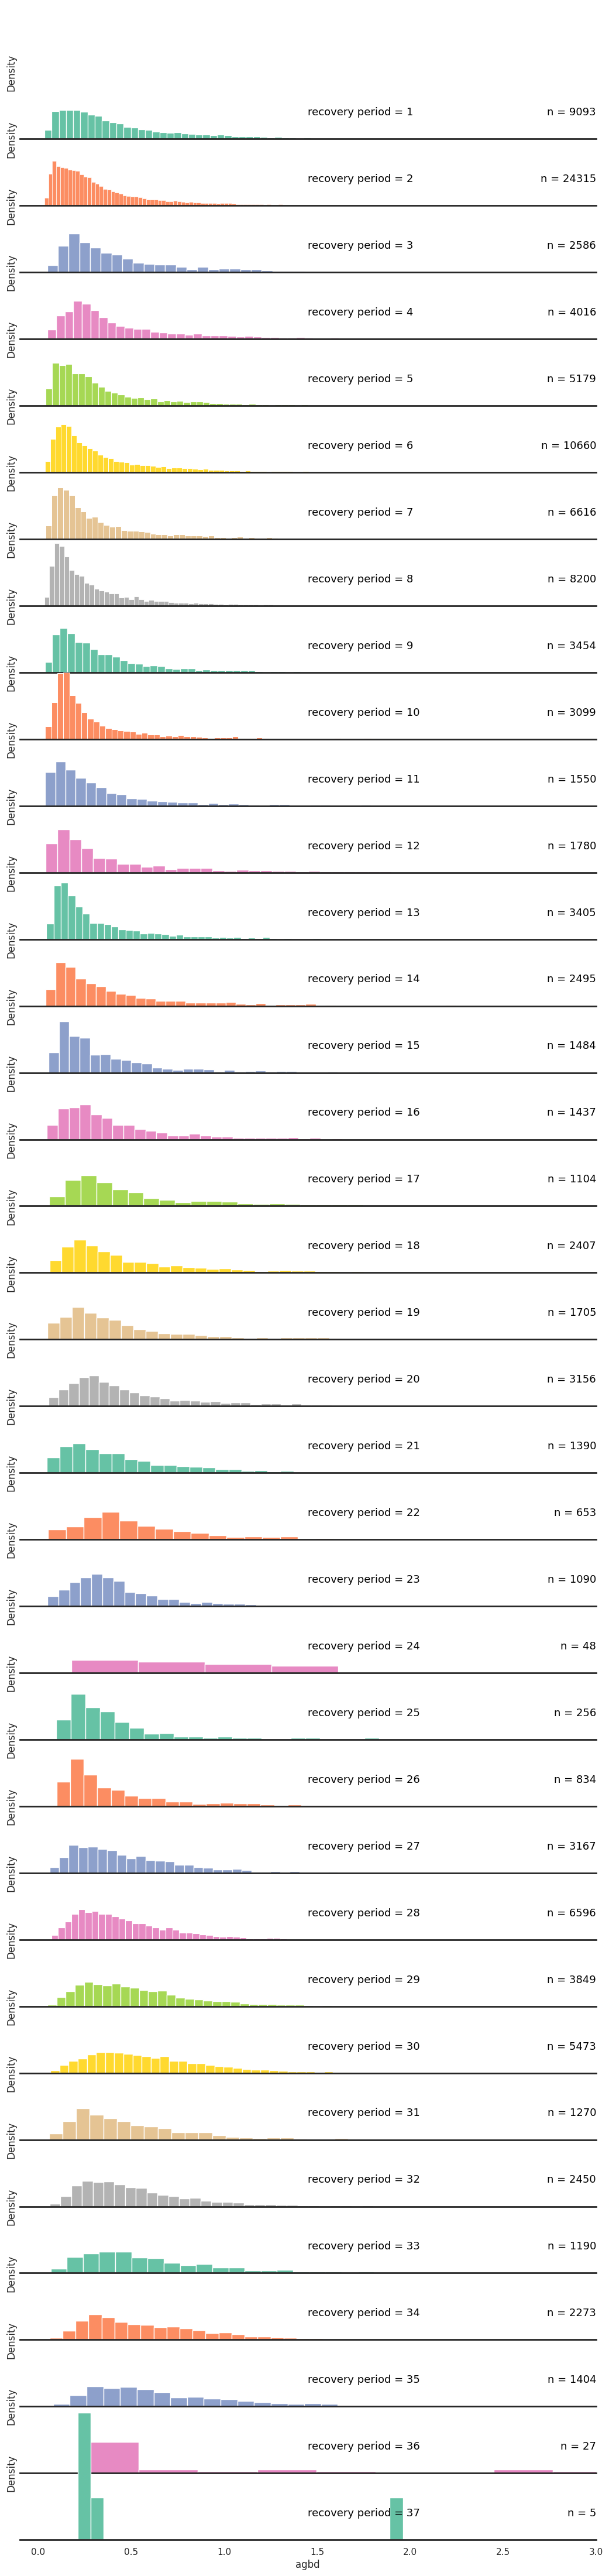

In [55]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0), 'axes.linewidth':2})
palette = sns.color_palette("Set2", 12)
g = sns.FacetGrid(gedi_recovery[gedi_recovery.severity=="High"], palette=palette, row="time_since_burn", hue="time_since_burn", aspect=9, height=1.2, xlim=[-0.1, 3])
g.map_dataframe(sns.histplot, x="rel_agbd", fill=True, alpha=1, stat='density')
#g.map_dataframe(sns.kdeplot, x="agcd", color='black')


def label(x, color, label):
    ax = plt.gca()
    ax.text(0.5, .2, f'recovery period = {label}', color='black', fontsize=13,
            ha="left", va="center", transform=ax.transAxes)
    ax.text(1, .2, f'n = {len(x)}', color='black', fontsize=13,
            ha='right', va='center', transform=ax.transAxes)
    
g.map(label, "time_since_burn")
g.fig.subplots_adjust(hspace=-.5)
g.set_titles("")
g.set(yticks=[], xlabel="agbd")
g.despine( left=True)